# This file uses the updated.csv with Major column

---



In [1]:
!pip install noisereduce
!pip install praat-parselmouth
!pip install --upgrade librosa
!pip install librosa scipy
!pip install pysptk
!pip install gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.9/461.9 kB 14.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pysptk: filename=pysptk-1.0.1-cp310-cp310-linux_x86_64.whl size=1241914 sha256=3aef40b917d1b7b12cad4e33c5318f130becab5ff8517f8aacd45738f5ef95a5
  Stored in directory: /root/.cache/pip/wheels/ba/c2/7f/73c54e1795eeca8f995f95474c8290b78ee0a6306412dc934f
Successfully built pysptk


In [2]:
import numpy as np
import os
import pandas as pd
import re
import librosa
import parselmouth
from parselmouth.praat import call
import scipy.stats as stats
import scipy
import pysptk
from scipy.io import wavfile
from tqdm import tqdm
from google.colab import drive

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Proceed with splitting the data and training the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Google Colab specific
drive.mount('/content/drive')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


## Load File

In [3]:
df = pd.read_csv('/content/drive/Shared drives/CS298/CS 297/IEMOCAP/IEMOCAP_Updated.csv')
df.dropna(subset=['Major'], inplace=True)
df.head()

,Session,Conversation,Audio_Path,Speaker_id,Transcript,Time_Frame,Major_emotion,Audio_Uttrance_Path,Major_Emotion,Major,...,Valence,Dominance,dimension,category,act,val,dom,New_Category,Final_class,Unnamed: 20
0,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_M000,Good God.,006.2551-008.1400,Frustration,/content/drive/My Drive/CS 297/IEMOCAP/Session...,"['Fear', 'Excited', 'Frustration']",Fear,...,"[3, 3]","[4, 4]","[{'arousal': 3.0, 'valence': 3.0, 'dominance':...","['Frustration', 'Fear', 'Excited']","2,4","3,3","4,4",Nervous,NaN,NaN
1,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_F000,Do you think it's them?,007.7500-009.1900,Frustration,/content/drive/My Drive/CS 297/IEMOCAP/Session...,"['Fear', 'Excited', 'Frustration']",Fear,...,"[4, 4]","[3, 4]","[{'arousal': 3.5, 'valence': 2.0, 'dominance':...","['Frustration', 'Fear', 'Excited']","2,5","2,2","3,4",Nervous,NaN,NaN
2,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_M001,I wonder.,008.6300-009.6700,Fear,/content/drive/My Drive/CS 297/IEMOCAP/Session...,"['Fear', 'Excited', 'Fear']",Fear,...,"[3, 3]","[3, 4]","[{'arousal': 3.0, 'valence': 3.0, 'dominance':...","['Fear', 'Fear', 'Excited']","2,4","3,3","3,4",Nervous,NaN,NaN
3,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_F001,Nobody knows we're here except Freda and she w...,009.2300-011.8600,Frustration,/content/drive/My Drive/CS 297/IEMOCAP/Session...,"['Fear', 'Excited', 'Frustration']",Fear,...,"[3, 4]","[3, 4]","[{'arousal': 4.0, 'valence': 2.5, 'dominance':...","['Frustration', 'Fear', 'Excited']","3,5","3,2","3,4",Nervous,NaN,NaN
4,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_M002,It must be them then.,011.4300-012.7900,Fear,/content/drive/My Drive/CS 297/IEMOCAP/Session...,"['Fear', 'Excited', 'Fear']",Fear,...,"[4, 3]","[3, 4]","[{'arousal': 3.0, 'valence': 2.5, 'dominance':...","['Fear', 'Fear', 'Excited']","2,4","2,3","3,4",Nervous,NaN,NaN


In [4]:
merged_df = df[['Speaker_id', 'Transcript', 'Major']].rename(columns={'Major': 'Emotion'})
emotion_mapping = {
    'Neutral state': 'neutral',
    'Frustration': 'sad',
    'Anger': 'angry',
    'Surprise': None,  # Assuming 'Surprise' to 'neutral' if not sure where to map
    'Disgust': None,  # Mapping 'Disgust' to 'angry' or consider removing if not relevant
    'Other': None,  # Remove 'Other' or map if it can be categorized
    'Sadness': 'sad',
    'Fear': None,  # Assuming 'Fear' to 'neutral' or map to 'angry' based on context
    'Happiness': 'happy',
    'Excited': 'happy'
}

# Apply the mapping to the Emotion column
merged_df['Emotion'] = merged_df['Emotion'].map(emotion_mapping)

# Remove any rows with None as Emotion (unmapped categories)
merged_df = merged_df.dropna(subset=['Emotion'])
merged_df
merged_df['Emotion'] = merged_df['Emotion'].str.strip().str.lower()

merged_df.head()

,Speaker_id,Transcript,Emotion
6,Ses04F_script03_1_M003,"We'll be alright, darling. Whatever happens, ...",happy
7,Ses04F_script03_1_F003,Now and always sweet.,happy
8,Ses04F_script03_1_M004,I don't care then.,happy
9,Ses04F_script03_1_F004,It was bound to come sooner or later.,happy
11,Ses04F_script03_1_F005,Ahh. It sent shivers up my spine.,happy


In [5]:
merged_df['Emotion'] = merged_df['Emotion'].replace('excited', 'happy')
merged_df = merged_df[~merged_df['Emotion'].str.contains('nervous', na=False)]


In [6]:
# Recalculate the emotion counts
emotion_counts = merged_df['Emotion'].value_counts()

# Print the updated counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

sad: 3650
happy: 2306
neutral: 2277
angry: 1278


In [7]:
stop_words = set(stopwords.words('english'))
# Consider removing negations from the stopword list if they are crucial for emotion detection
negations = {"not", "no", "never", "none", "nothing", "neither", "nowhere", "hardly", "scarcely", "barely", "don’t", "isn’t", "wasn’t", "shouldn’t", "wouldn’t", "couldn’t", "won’t"}
stop_words = stop_words - negations

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase to standardize the text
    text = text.lower()
    '''
    # Split text into words
    words = text.split()

    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    # Rejoin words to form the cleaned text
    text = ' '.join(filtered_words)
    '''
    return text

# Apply the preprocessing function to the 'Transcript' column
merged_df['Transcript'] = merged_df['Transcript'].apply(preprocess_text)

# Display the first few entries to verify changes
merged_df.head()


,Speaker_id,Transcript,Emotion
6,Ses04F_script03_1_M003,"we'll be alright, darling. whatever happens, ...",happy
7,Ses04F_script03_1_F003,now and always sweet.,happy
8,Ses04F_script03_1_M004,i don't care then.,happy
9,Ses04F_script03_1_F004,it was bound to come sooner or later.,happy
11,Ses04F_script03_1_F005,ahh. it sent shivers up my spine.,happy


In [ ]:

# Assuming 'merged_df' is your DataFrame containing the 'Emotion' and 'Transcript' columns

# Text preprocessing
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(merged_df['Transcript'])
y = merged_df['Emotion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict the test set results
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5249605885444035
              precision    recall  f1-score   support

       angry       0.67      0.29      0.40       283
       happy       0.61      0.59      0.60       441
     neutral       0.48      0.27      0.35       495
         sad       0.49      0.76      0.60       684

    accuracy                           0.52      1903
   macro avg       0.56      0.48      0.49      1903
weighted avg       0.54      0.52      0.50      1903



In [ ]:

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=1000)

# Apply the vectorizer to the Transcript column
X = vectorizer.fit_transform(merged_df['Transcript'])
y = merged_df['Emotion']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Predict the emotions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.5228586442459274
              precision    recall  f1-score   support

       angry       0.65      0.34      0.44       283
       happy       0.64      0.56      0.60       441
     neutral       0.45      0.25      0.32       495
         sad       0.48      0.77      0.59       684

    accuracy                           0.52      1903
   macro avg       0.56      0.48      0.49      1903
weighted avg       0.54      0.52      0.50      1903



# Bulding Deep Models

In [8]:
merged_df['Transcript'].apply(lambda x: len(x.split())).max()

100

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Generate an array of indices the same length as dataset
# Text tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(merged_df['Transcript'])
sequences = tokenizer.texts_to_sequences(merged_df['Transcript'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
indices = np.arange(padded_sequences.shape[0])

# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(merged_df['Emotion'])
y = tf.keras.utils.to_categorical(y)  # Convert labels to one-hot encoding

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    padded_sequences, y, indices, test_size=0.2, random_state=42)

In [ ]:

# Initialize the Adam optimizer with a custom learning rate
learning_rate = 0.001  # You can adjust this value
optimizer = Adam(learning_rate=learning_rate)


In [ ]:


def evaluate_model(model, X_test, y_test, history, class_labels):
    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("Test Accuracy:", test_acc)

    # Predict the test set results for F1 and Confusion Matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute the F1 Score
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    print("F1 Score:", f1)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print("Confusion Matrix:\n", cm)

    # Classification report
    print(classification_report(y_true_classes, y_pred_classes))

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()




In [ ]:
def model_1(vocab_size, output_size):
    tf.random.set_seed(42)
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=40, input_length=85),
        Bidirectional(LSTM(100)),
        Dense(output_size, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:


vocab_size = 10000  # or len(tokenizer.word_index) + 1
output_size = len(encoder.classes_)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
# Initialize the model
model = model_1(vocab_size, output_size)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test),
                    batch_size=32, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 47s 169ms/step - accuracy: 0.3851 - loss: 1.3166 - val_accuracy: 0.4225 - val_loss: 1.2225
Epoch 2/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accuracy: 0.5172 - loss: 1.1157 - val_accuracy: 0.5166 - val_loss: 1.0822
Epoch 3/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 176ms/step - accuracy: 0.6087 - loss: 0.9427 - val_accuracy: 0.5239 - val_loss: 1.0782
Epoch 4/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.6488 - loss: 0.8535 - val_accuracy: 0.5455 - val_loss: 1.0813
Epoch 5/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - accuracy: 0.6761 - loss: 0.7929 - val_accuracy: 0.5497 - val_loss: 1.1085
Epoch 6/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 42s 174ms/step - accuracy: 0.6998 - loss: 0.7464 - val_accuracy: 0.5439 - val_loss: 1.1304
Epoch 7/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accuracy: 0.7077 - loss: 0.7149 - val_accuracy: 0.5455 - val_loss: 1.1796
Epoch 8/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.7226 - loss: 0.6709 - val

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5295 - loss: 1.0752
Test Accuracy: 0.5239096283912659
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
F1 Score: 0.5194171824913824
Confusion Matrix:
 [[ 77   8  41 157]
 [  3 246 127  65]
 [  4  77 233 181]
 [ 29  34 180 441]]
              precision    recall  f1-score   support

           0       0.68      0.27      0.39       283
           1       0.67      0.56      0.61       441
           2       0.40      0.47      0.43       495
           3       0.52      0.64      0.58       684

    accuracy                           0.52      1903
   macro avg       0.57      0.49      0.50      1903
weighted avg       0.55      0.52      0.52      1903



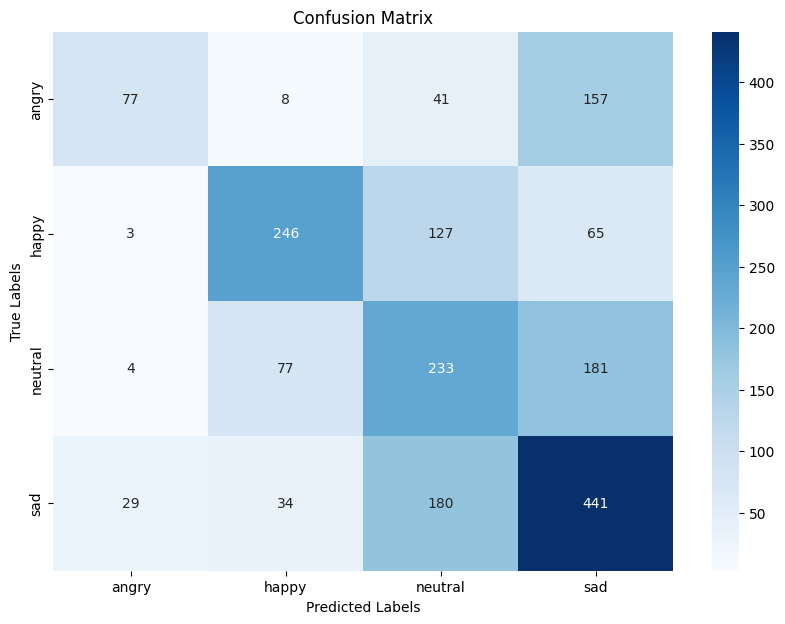

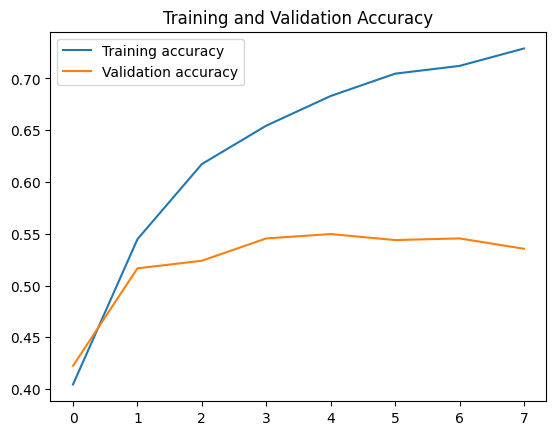

In [ ]:
evaluate_model(model, X_test, y_test, history, encoder.classes_)


### Attention

In [ ]:

class Attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(Attention, self).build(input_shape)

    def call(self, x):
        # Applying the attention mechanism
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)


def build_model(vocab_size, output_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=85),
        Bidirectional(LSTM(100, return_sequences=True)),
        Attention(return_sequences=False),  # Use attention mechanism
        Dense(64, activation='relu'),
        Dense(output_size, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# Example usage
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
model = build_model(vocab_size=10000, output_size=4)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 53s 201ms/step - accuracy: 0.3812 - loss: 1.3303 - val_accuracy: 0.3594 - val_loss: 1.3396
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 50s 208ms/step - accuracy: 0.3963 - loss: 1.3013 - val_accuracy: 0.4430 - val_loss: 1.2132
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 80s 201ms/step - accuracy: 0.5169 - loss: 1.1002 - val_accuracy: 0.5123 - val_loss: 1.1103
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 201ms/step - accuracy: 0.5973 - loss: 0.9634 - val_accuracy: 0.5334 - val_loss: 1.0841
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 81s 199ms/step - accuracy: 0.6449 - loss: 0.8801 - val_accuracy: 0.5544 - val_loss: 1.0716
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 199ms/step - accuracy: 0.6746 - loss: 0.8169 - val_accuracy: 0.5560 - val_loss: 1.0833
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.6933 - loss: 0.7643 - val_accuracy: 0.5518 - val_loss: 1.1088
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 199ms/step - accuracy: 0.7126 - loss: 0.7197 - val

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.5253 - loss: 3.3209
Test Accuracy: 0.5302154421806335
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step
F1 Score: 0.5250778972069984
Confusion Matrix:
 [[152   7  30  94]
 [ 21 256  76  88]
 [ 47 104 173 171]
 [ 92  63 101 428]]
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       283
           1       0.60      0.58      0.59       441
           2       0.46      0.35      0.40       495
           3       0.55      0.63      0.58       684

    accuracy                           0.53      1903
   macro avg       0.52      0.52      0.52      1903
weighted avg       0.53      0.53      0.53      1903



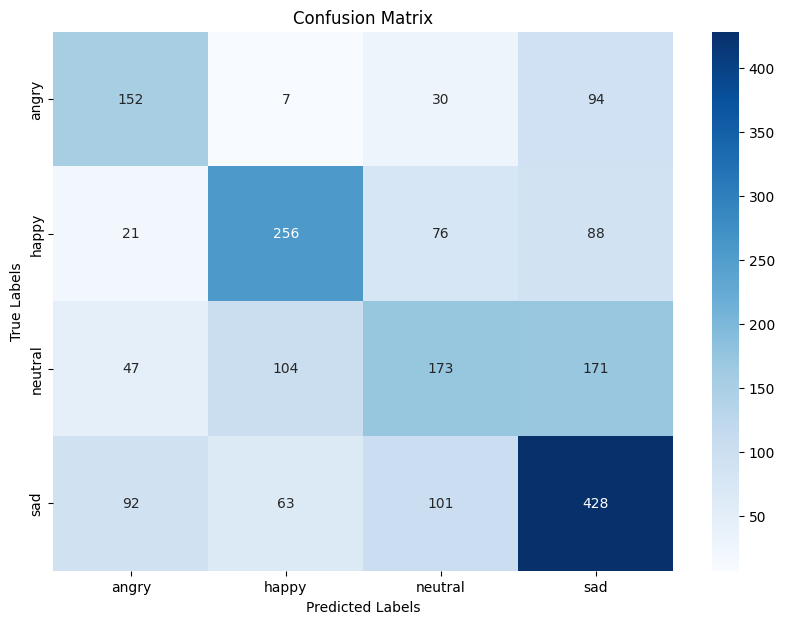

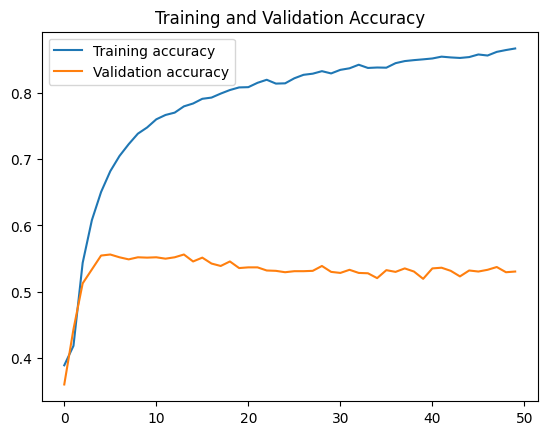

In [ ]:
evaluate_model(model, X_test, y_test, history, encoder.classes_)


In [ ]:

speaker_ids_test = merged_df.iloc[idx_test]['Speaker_id'].tolist()

def evaluate_and_display_predictions_with_transcript_and_speaker(model, X_test, y_test, idx_test, class_labels, speaker_ids):
    # Predict the test set results
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Fetch transcripts and speaker_ids based on test indices
    transcripts = merged_df.iloc[idx_test]['Transcript'].tolist()

    # Convert numeric labels back to original labels
    predicted_labels = [class_labels[i] for i in y_pred_classes]
    true_labels = [class_labels[i] for i in y_true_classes]

    # Create a DataFrame to display the speaker_id, transcripts, true labels, predicted labels
    results_df = pd.DataFrame({
        'Speaker ID': speaker_ids,
        'Transcript': transcripts,
        'True Label': true_labels,
        'Predicted Label': predicted_labels,
        'Predicted Probability': np.max(y_pred, axis=1)
    })



    return results_df  # Return the DataFrame in case you need it for further analysis

# Usage of the function
class_labels = encoder.classes_
results_df = evaluate_and_display_predictions_with_transcript_and_speaker(model, X_test, y_test, idx_test, class_labels, speaker_ids_test)


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step


In [ ]:
# Display the DataFrame
results_df

,Speaker ID,Transcript,True Label,Predicted Label,Predicted Probability
0,Ses03M_impro03_F021,"okay, that is really cheesy joe.",happy,angry,0.977827
1,Ses01M_impro04_M006,"what's my--like what do you mean ""my attitude""?",sad,angry,0.926691
2,Ses05M_impro04_F006,no. i'm just working in restaurants and stuff...,neutral,happy,0.960989
3,Ses05F_script02_1_F016,yes.,neutral,angry,0.493577
4,Ses02F_script01_1_F000,what's he gonna say? maybe we ought to tell h...,neutral,sad,0.999868
...,...,...,...,...,...
1898,Ses02F_impro02_F007,"and--i mean, my daughter--i don't want to put ...",sad,sad,0.998567
1899,Ses05F_script03_1_M002,it must be them then.,happy,sad,0.900881
1900,Ses03M_impro07_M025,"it took them, oh man, it took them like, i mea...",happy,happy,0.998135
1901,Ses01M_impro05_M003,"yes, georgia. good for you i need my bag. ca...",sad,sad,0.753947


# **Model 2**

In [ ]:
def build_model_2(vocab_size, output_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=85, trainable=True),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        Attention(return_sequences=False),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(output_size, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
model2 = build_model_2(vocab_size=10000, output_size=4)
history = model2.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 95s 356ms/step - accuracy: 0.3814 - loss: 1.3340 - val_accuracy: 0.3594 - val_loss: 1.3395
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 139s 343ms/step - accuracy: 0.3915 - loss: 1.3130 - val_accuracy: 0.4430 - val_loss: 1.2560
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 90s 376ms/step - accuracy: 0.4951 - loss: 1.1489 - val_accuracy: 0.5076 - val_loss: 1.1044
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 136s 350ms/step - accuracy: 0.5810 - loss: 0.9745 - val_accuracy: 0.5344 - val_loss: 1.0639
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 159s 422ms/step - accuracy: 0.6342 - loss: 0.8897 - val_accuracy: 0.5497 - val_loss: 1.0540
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 132s 378ms/step - accuracy: 0.6633 - loss: 0.8205 - val_accuracy: 0.5481 - val_loss: 1.0644
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 89s 375ms/step - accuracy: 0.6942 - loss: 0.7632 - val_accuracy: 0.5507 - val_loss: 1.1018
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 135s 345ms/step - accuracy: 0.7079 - loss: 0.7265 

KeyboardInterrupt: 

In [ ]:
evaluate_model(model2, X_test, y_test, history, encoder.classes_)


# Word2Vec embeddings

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec

# Prepare the Word2Vec embeddings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(merged_df['Transcript'])
sequences = tokenizer.texts_to_sequences(merged_df['Transcript'])
word_index = tokenizer.word_index
reversed_word_map = dict(map(reversed, tokenizer.word_index.items()))
sentences = [[reversed_word_map.get(letter) for letter in seq] for seq in sequences]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    try:
        embedding_vector = word2vec_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except KeyError:
        continue  # Words not found in the embedding index will be all-zeros.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert sequences to padded sequences
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Prepare the data matrix X
X = np.zeros((len(padded_sequences), max_length, 100))  # assuming each Word2Vec vector is 100-dimensional
for i, sequence in enumerate(padded_sequences):
    for j, index in enumerate(sequence):
        X[i, j] = embedding_matrix[index] if index > 0 else np.zeros(100)

In [ ]:
def evaluate_model(model, X_test, y_test, history, class_labels):
    test_loss, test_acc = model.evaluate(X_test, y_test)
    #print("Test Accuracy:", test_acc)
    #accuracies.append(test_acc)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    #print("F1 Score:", f1)
    #f1_scores.append(f1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print(classification_report(y_true_classes, y_pred_classes))

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return test_acc, f1, cm

Training fold 1
Epoch 1/100
238/238 - 42s - 176ms/step - accuracy: 0.4122 - loss: 1.2791 - val_accuracy: 0.4120 - val_loss: 1.2608
Epoch 2/100
238/238 - 34s - 143ms/step - accuracy: 0.5388 - loss: 1.0818 - val_accuracy: 0.5286 - val_loss: 1.0977
Epoch 3/100
238/238 - 41s - 174ms/step - accuracy: 0.6216 - loss: 0.9283 - val_accuracy: 0.5497 - val_loss: 1.0554
Epoch 4/100
238/238 - 45s - 191ms/step - accuracy: 0.6552 - loss: 0.8437 - val_accuracy: 0.5423 - val_loss: 1.0973
Epoch 5/100
238/238 - 36s - 152ms/step - accuracy: 0.6777 - loss: 0.7845 - val_accuracy: 0.5455 - val_loss: 1.1049
Epoch 6/100
238/238 - 41s - 173ms/step - accuracy: 0.7031 - loss: 0.7403 - val_accuracy: 0.5659 - val_loss: 1.0934
Epoch 7/100
238/238 - 45s - 190ms/step - accuracy: 0.7162 - loss: 0.7065 - val_accuracy: 0.5644 - val_loss: 1.0972
Epoch 8/100
238/238 - 36s - 153ms/step - accuracy: 0.7227 - loss: 0.6768 - val_accuracy: 0.5554 - val_loss: 1.1350
Epoch 9/100
238/238 - 41s - 173ms/step - accuracy: 0.7284 - loss

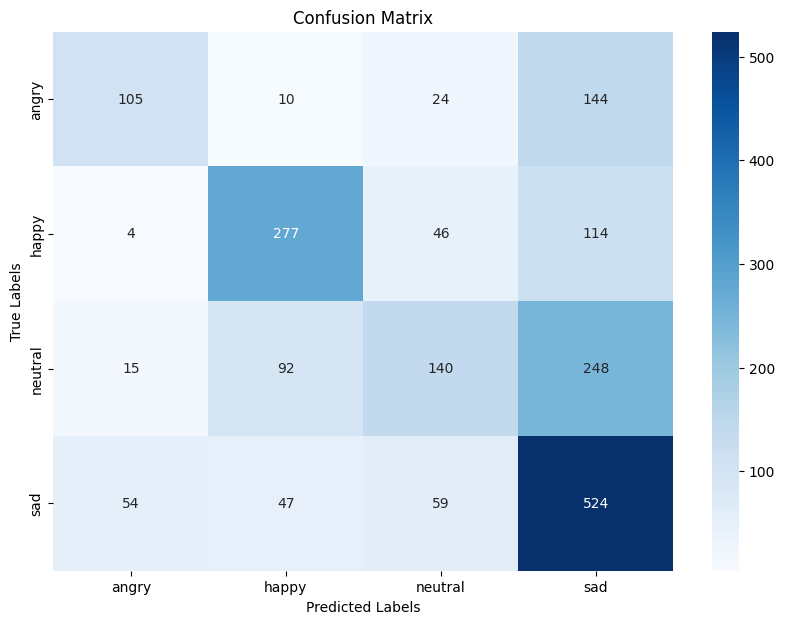

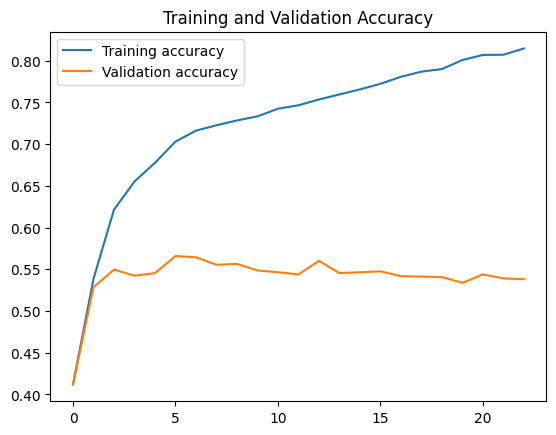

Tet Accuracy: 0.5496584177017212
F1 Score: 0.5309212322792883
Confusion Matrix:
 [[105  10  24 144]
 [  4 277  46 114]
 [ 15  92 140 248]
 [ 54  47  59 524]]
*********************************************
Training fold 2
Epoch 1/100
238/238 - 42s - 178ms/step - accuracy: 0.4064 - loss: 1.2779 - val_accuracy: 0.5042 - val_loss: 1.1722
Epoch 2/100
238/238 - 34s - 143ms/step - accuracy: 0.5547 - loss: 1.0376 - val_accuracy: 0.5347 - val_loss: 1.0934
Epoch 3/100
238/238 - 36s - 153ms/step - accuracy: 0.6236 - loss: 0.9039 - val_accuracy: 0.5620 - val_loss: 1.0728
Epoch 4/100
238/238 - 39s - 165ms/step - accuracy: 0.6617 - loss: 0.8260 - val_accuracy: 0.5542 - val_loss: 1.0834
Epoch 5/100
238/238 - 44s - 184ms/step - accuracy: 0.6868 - loss: 0.7711 - val_accuracy: 0.5720 - val_loss: 1.0749
Epoch 6/100
238/238 - 38s - 159ms/step - accuracy: 0.7056 - loss: 0.7286 - val_accuracy: 0.5557 - val_loss: 1.1420
Epoch 7/100
238/238 - 41s - 171ms/step - accuracy: 0.7161 - loss: 0.7013 - val_accuracy: 0

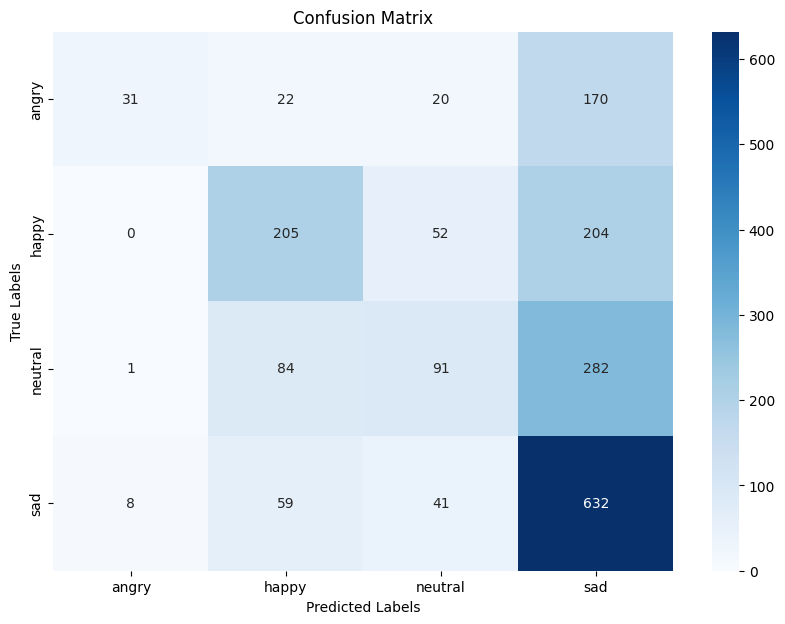

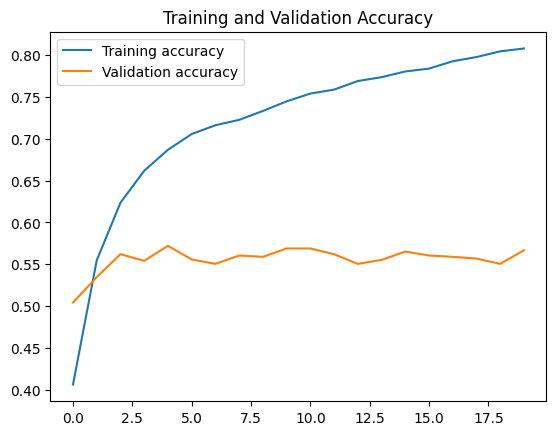

Tet Accuracy: 0.504206120967865
F1 Score: 0.45626913430864785
Confusion Matrix:
 [[ 31  22  20 170]
 [  0 205  52 204]
 [  1  84  91 282]
 [  8  59  41 632]]
*********************************************
Training fold 3
Epoch 1/100
238/238 - 40s - 170ms/step - accuracy: 0.4213 - loss: 1.2756 - val_accuracy: 0.5068 - val_loss: 1.1672
Epoch 2/100
238/238 - 35s - 145ms/step - accuracy: 0.5520 - loss: 1.0504 - val_accuracy: 0.5673 - val_loss: 1.0376
Epoch 3/100
238/238 - 41s - 171ms/step - accuracy: 0.6189 - loss: 0.9170 - val_accuracy: 0.5752 - val_loss: 1.0295
Epoch 4/100
238/238 - 44s - 186ms/step - accuracy: 0.6555 - loss: 0.8428 - val_accuracy: 0.5820 - val_loss: 1.0191
Epoch 5/100
238/238 - 39s - 164ms/step - accuracy: 0.6789 - loss: 0.7853 - val_accuracy: 0.5699 - val_loss: 1.0495
Epoch 6/100
238/238 - 39s - 166ms/step - accuracy: 0.6977 - loss: 0.7454 - val_accuracy: 0.5789 - val_loss: 1.0726
Epoch 7/100
238/238 - 41s - 171ms/step - accuracy: 0.7102 - loss: 0.7074 - val_accuracy: 0

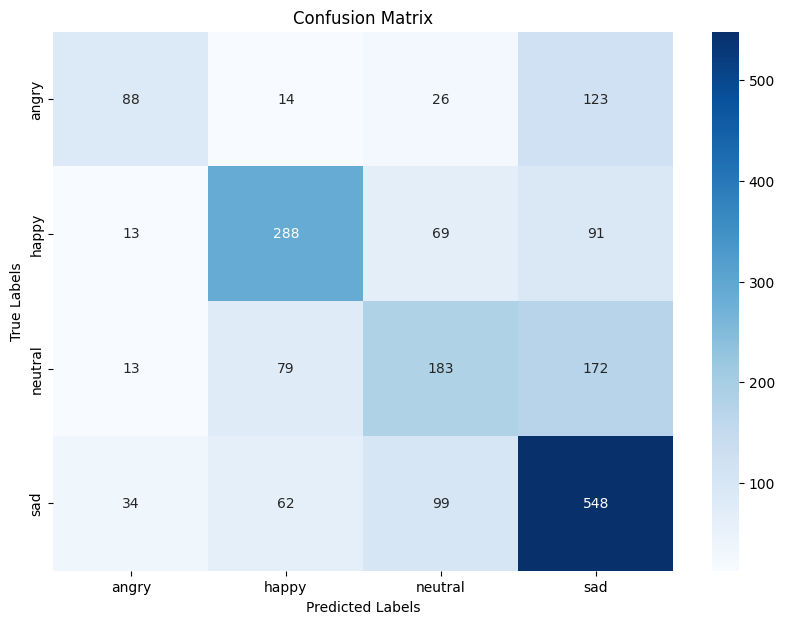

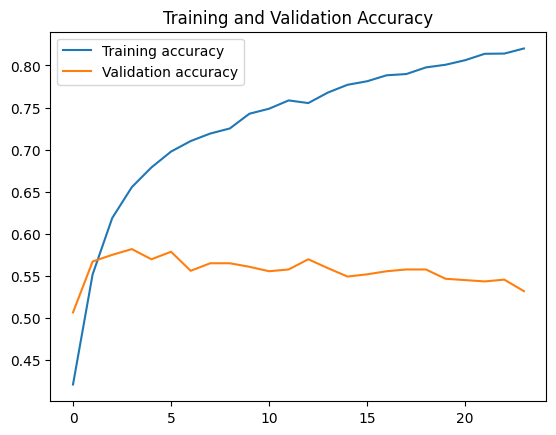

Tet Accuracy: 0.5820189118385315
F1 Score: 0.5723362710469784
Confusion Matrix:
 [[ 88  14  26 123]
 [ 13 288  69  91]
 [ 13  79 183 172]
 [ 34  62  99 548]]
*********************************************
Training fold 4
Epoch 1/100
238/238 - 38s - 161ms/step - accuracy: 0.4124 - loss: 1.2741 - val_accuracy: 0.5005 - val_loss: 1.1660
Epoch 2/100
238/238 - 39s - 163ms/step - accuracy: 0.5491 - loss: 1.0476 - val_accuracy: 0.5647 - val_loss: 1.0299
Epoch 3/100
238/238 - 37s - 154ms/step - accuracy: 0.6185 - loss: 0.9235 - val_accuracy: 0.5710 - val_loss: 0.9999
Epoch 4/100
238/238 - 42s - 175ms/step - accuracy: 0.6515 - loss: 0.8513 - val_accuracy: 0.5773 - val_loss: 1.0144
Epoch 5/100
238/238 - 34s - 144ms/step - accuracy: 0.6783 - loss: 0.7890 - val_accuracy: 0.5673 - val_loss: 1.0492
Epoch 6/100
238/238 - 41s - 173ms/step - accuracy: 0.6894 - loss: 0.7499 - val_accuracy: 0.5868 - val_loss: 1.0251
Epoch 7/100
238/238 - 42s - 178ms/step - accuracy: 0.7068 - loss: 0.7149 - val_accuracy: 0

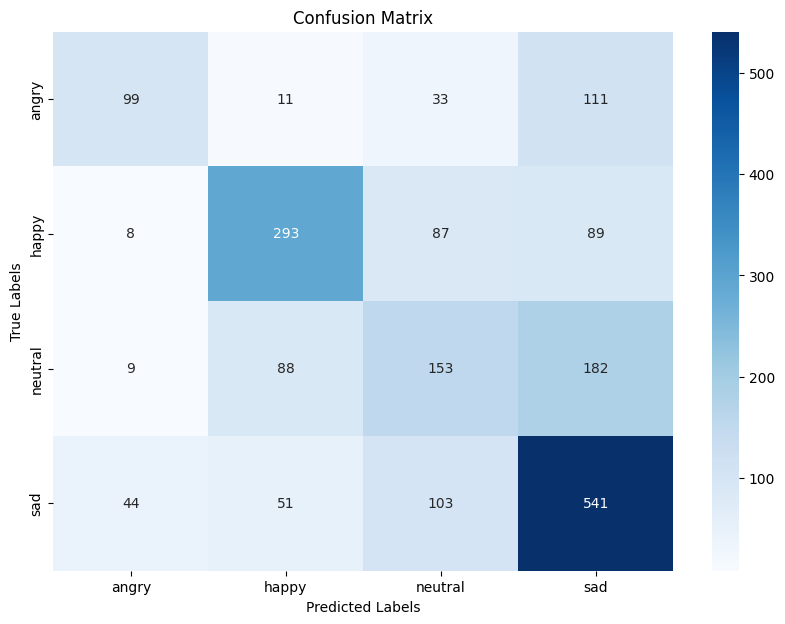

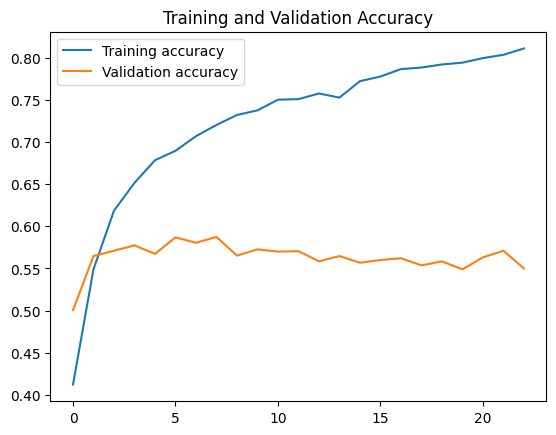

Tet Accuracy: 0.5709779262542725
F1 Score: 0.5625743315696102
Confusion Matrix:
 [[ 99  11  33 111]
 [  8 293  87  89]
 [  9  88 153 182]
 [ 44  51 103 541]]
*********************************************
Training fold 5
Epoch 1/100
238/238 - 40s - 168ms/step - accuracy: 0.4209 - loss: 1.2679 - val_accuracy: 0.4890 - val_loss: 1.1748
Epoch 2/100
238/238 - 37s - 155ms/step - accuracy: 0.5576 - loss: 1.0458 - val_accuracy: 0.5389 - val_loss: 1.0663
Epoch 3/100
238/238 - 40s - 166ms/step - accuracy: 0.6220 - loss: 0.9146 - val_accuracy: 0.5668 - val_loss: 1.0297
Epoch 4/100
238/238 - 40s - 167ms/step - accuracy: 0.6616 - loss: 0.8248 - val_accuracy: 0.5668 - val_loss: 1.0427
Epoch 5/100
238/238 - 35s - 148ms/step - accuracy: 0.6934 - loss: 0.7654 - val_accuracy: 0.5789 - val_loss: 1.0538
Epoch 6/100
238/238 - 40s - 169ms/step - accuracy: 0.7069 - loss: 0.7262 - val_accuracy: 0.5647 - val_loss: 1.1034
Epoch 7/100
238/238 - 41s - 172ms/step - accuracy: 0.7203 - loss: 0.6920 - val_accuracy: 0

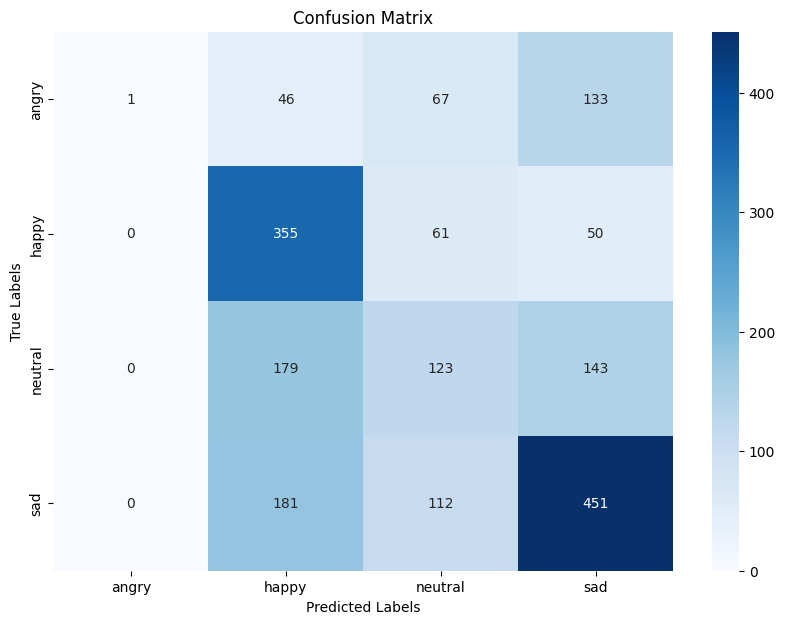

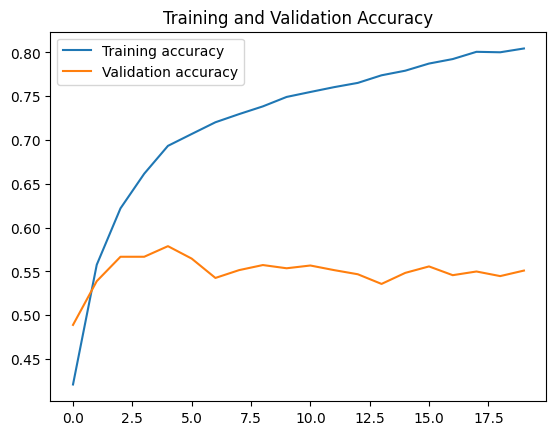

Tet Accuracy: 0.4889589846134186
F1 Score: 0.4460247900323375
Confusion Matrix:
 [[  1  46  67 133]
 [  0 355  61  50]
 [  0 179 123 143]
 [  0 181 112 451]]
*********************************************
Average F1 Score across all folds: 0.5136251518473725
Average Accuracy across all folds: 0.5391640722751617


In [ ]:

class Attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(Attention, self).build(input_shape)

    def call(self, x):
        # Applying the attention mechanism
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

'''
def build_model():
    vocab_size, embedding_dim = embedding_matrix.shape
    model = Sequential([
        # Embedding layer expects integer indices
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],  trainable=False),
        Bidirectional(LSTM(100, return_sequences=True)),
        Attention(return_sequences=False),  # Ensure Attention class is correctly implemented
        Dense(64, activation='relu'),
        Dense(y.shape[1], activation='softmax')  # Adjust the number of output classes dynamically
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
'''
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
vocab_size = 10000  # or len(tokenizer.word_index) + 1
output_size = len(encoder.classes_)
def build_model():
    vocab_size, embedding_dim = embedding_matrix.shape
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=40),
        Bidirectional(LSTM(100)),
        Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

X = padded_sequences
# Setup K-Fold Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
f1_scores = []
accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create and train the model
    model = build_model()
    print(f'Training fold {fold_no}')
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, verbose = 2, callbacks=[early_stopping])

    # Evaluate the model
    print(f'Evaluating fold {fold_no}')
    test_acc, f1, cm = evaluate_model(model, X_test, y_test, history, encoder.classes_)
    print("Tet Accuracy:", test_acc)
    accuracies.append(test_acc)
    print("F1 Score:", f1)
    f1_scores.append(f1)
    print("Confusion Matrix:\n", cm)
    fold_no+=1
    print('*********************************************')
# Print average scores
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)
print(f'Average F1 Score across all folds: {average_f1_score}')
print(f'Average Accuracy across all folds: {average_accuracy}')


# BERT EMBEDDING

In [9]:
! pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 6.0 MB/s eta 0:00:00


In [10]:
def evaluate_model(model, X_test, y_test, history, class_labels):
    test_loss, test_acc = model.evaluate(X_test, y_test)
    #print("Test Accuracy:", test_acc)
    #accuracies.append(test_acc)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    #print("F1 Score:", f1)
    #f1_scores.append(f1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print(classification_report(y_true_classes, y_pred_classes))

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return test_acc, f1, cm

In [12]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # This is a smaller, faster version but still effective.
# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(merged_df['Emotion'])
y = tf.keras.utils.to_categorical(y)  # Convert labels to one-hot encoding
output_size = len(encoder.classes_)

# Generate embeddings
transcripts = merged_df['Transcript'].tolist()
embeddings = model.encode(transcripts, show_progress_bar=True)


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training fold 1
Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4098 - loss: 1.2618 - val_accuracy: 0.4861 - val_loss: 1.1303
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5484 - loss: 1.0592 - val_accuracy: 0.5318 - val_loss: 1.0769
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5987 - loss: 0.9532 - val_accuracy: 0.5523 - val_loss: 1.0458
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6558 - loss: 0.8357 - val_accuracy: 0.5607 - val_loss: 1.0153
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7027 - loss: 0.7578 - val_accuracy: 0.5654 - val_loss: 1.0215
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7321 - loss: 0.6858 - val_accuracy: 0.5628 - val_loss: 1.0610
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7689 - loss: 0.6057 - val_accuracy: 0.5649 - val_loss: 1.0685
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7930 - loss: 0

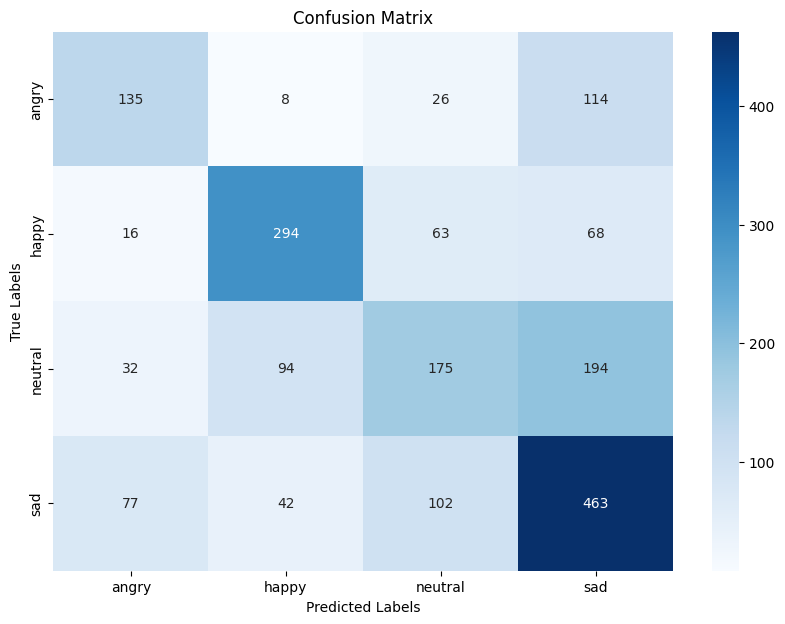

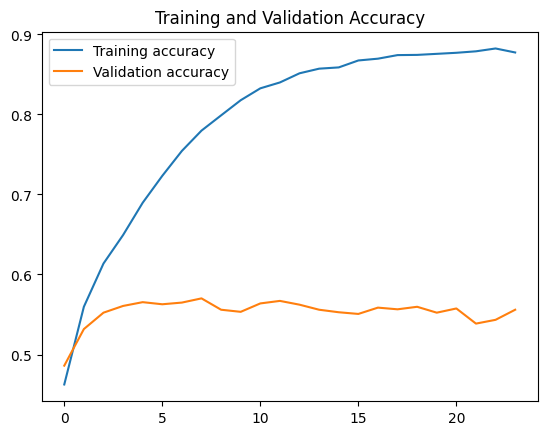

Tet Accuracy: 0.560693621635437
F1 Score: 0.5532424293358222
Confusion Matrix:
 [[135   8  26 114]
 [ 16 294  63  68]
 [ 32  94 175 194]
 [ 77  42 102 463]]
*********************************************
Training fold 2
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4046 - loss: 1.2783 - val_accuracy: 0.5147 - val_loss: 1.1121
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5359 - loss: 1.0685 - val_accuracy: 0.5463 - val_loss: 1.0587
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5960 - loss: 0.9562 - val_accuracy: 0.5726 - val_loss: 1.0255
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6535 - loss: 0.8561 - val_accuracy: 0.5731 - val_loss: 1.0124
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6935 - loss: 0.7704 - val_accuracy: 0.5857 - val_loss: 1.0280
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7308 - loss: 0.6919 - val_accuracy: 0.5778 - val_loss: 1.0396
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7528 - loss: 0.6163 - val_accuracy: 0.5778 - val_loss: 1.0774
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7783 - loss: 0.5710 - val_accuracy: 0.5589

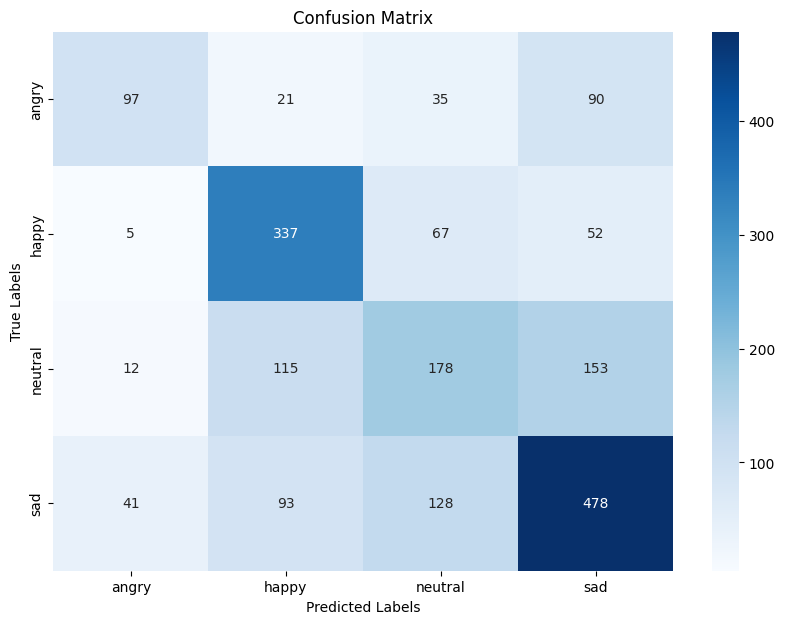

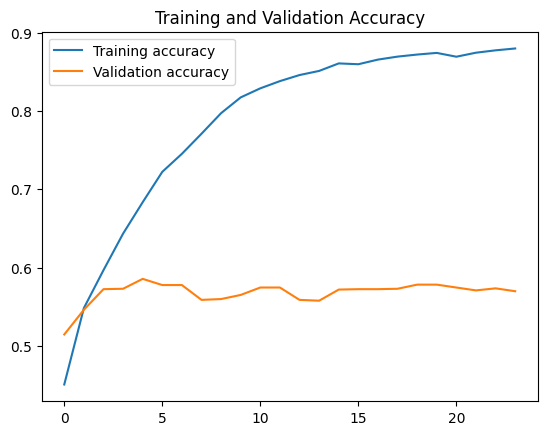

Tet Accuracy: 0.5730809569358826
F1 Score: 0.5661640407633011
Confusion Matrix:
 [[ 97  21  35  90]
 [  5 337  67  52]
 [ 12 115 178 153]
 [ 41  93 128 478]]
*********************************************
Training fold 3
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4114 - loss: 1.2732 - val_accuracy: 0.5452 - val_loss: 1.0939
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5434 - loss: 1.0608 - val_accuracy: 0.5510 - val_loss: 1.0380
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6079 - loss: 0.9473 - val_accuracy: 0.5657 - val_loss: 1.0002
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6502 - loss: 0.8648 - val_accuracy: 0.5852 - val_loss: 0.9786
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6807 - loss: 0.7746 - val_accuracy: 0.5831 - val_loss: 0.9960
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7218 - loss: 0.6978 - val_accuracy: 0.5878 - val_loss: 0.9979
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7749 - loss: 0.6162 - val_accuracy: 0.5868 - val_loss: 1.0209
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7783 - loss: 0.5624 - val_accuracy: 0.581

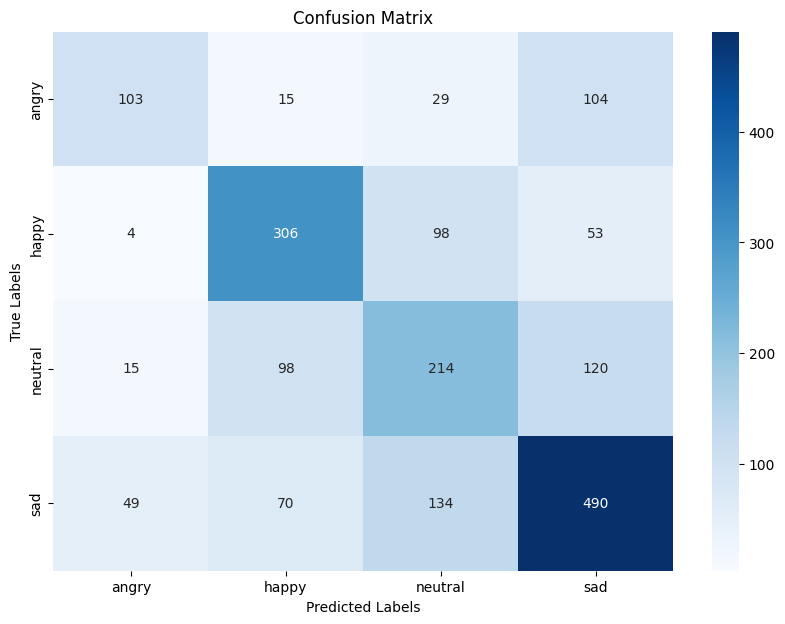

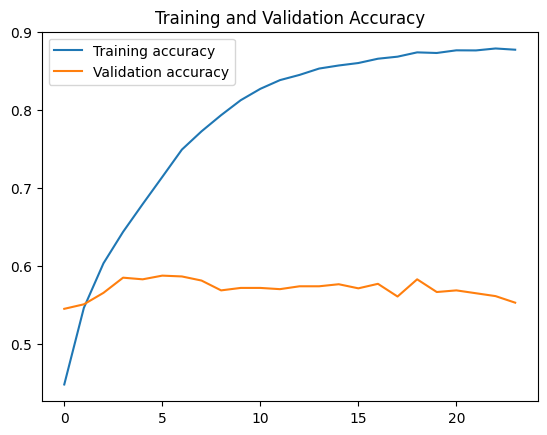

Tet Accuracy: 0.585173487663269
F1 Score: 0.5831861851265981
Confusion Matrix:
 [[103  15  29 104]
 [  4 306  98  53]
 [ 15  98 214 120]
 [ 49  70 134 490]]
*********************************************
Training fold 4
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4079 - loss: 1.2745 - val_accuracy: 0.5105 - val_loss: 1.0985
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5503 - loss: 1.0627 - val_accuracy: 0.5605 - val_loss: 1.0186
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5987 - loss: 0.9587 - val_accuracy: 0.5794 - val_loss: 0.9827
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6466 - loss: 0.8714 - val_accuracy: 0.5983 - val_loss: 0.9714
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6902 - loss: 0.7757 - val_accuracy: 0.6088 - val_loss: 0.9657
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7241 - loss: 0.6911 - val_accuracy: 0.5994 - val_loss: 0.9794
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7601 - loss: 0.6328 - val_accuracy: 0.5889 - val_loss: 1.0149
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7815 - loss: 0.5649 - val_accuracy: 0.5

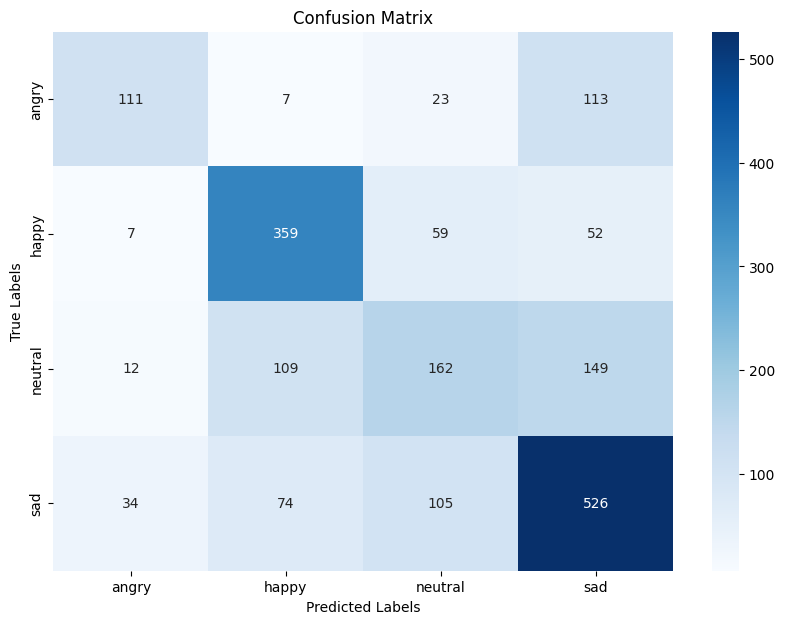

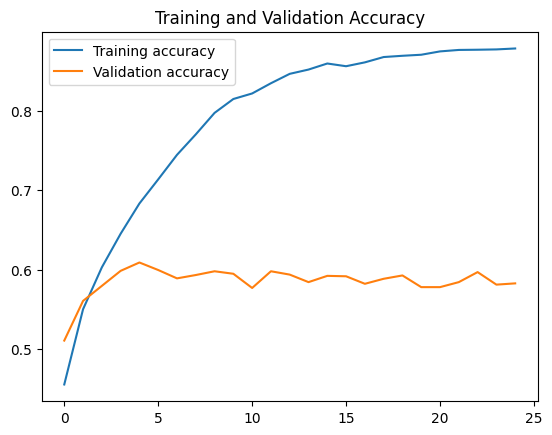

Tet Accuracy: 0.608832836151123
F1 Score: 0.5995150279518175
Confusion Matrix:
 [[111   7  23 113]
 [  7 359  59  52]
 [ 12 109 162 149]
 [ 34  74 105 526]]
*********************************************
Training fold 5
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4114 - loss: 1.2729 - val_accuracy: 0.5152 - val_loss: 1.1138
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5496 - loss: 1.0480 - val_accuracy: 0.5589 - val_loss: 1.0463
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6173 - loss: 0.9438 - val_accuracy: 0.5694 - val_loss: 1.0142
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6548 - loss: 0.8463 - val_accuracy: 0.5710 - val_loss: 1.0069
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6831 - loss: 0.7679 - val_accuracy: 0.5762 - val_loss: 1.0084
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7349 - loss: 0.6782 - val_accuracy: 0.5783 - val_loss: 1.0424
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7580 - loss: 0.6170 - val_accuracy: 0.5794 - val_loss: 1.0670
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7825 - loss: 0.5607 - val_accuracy: 0.5836

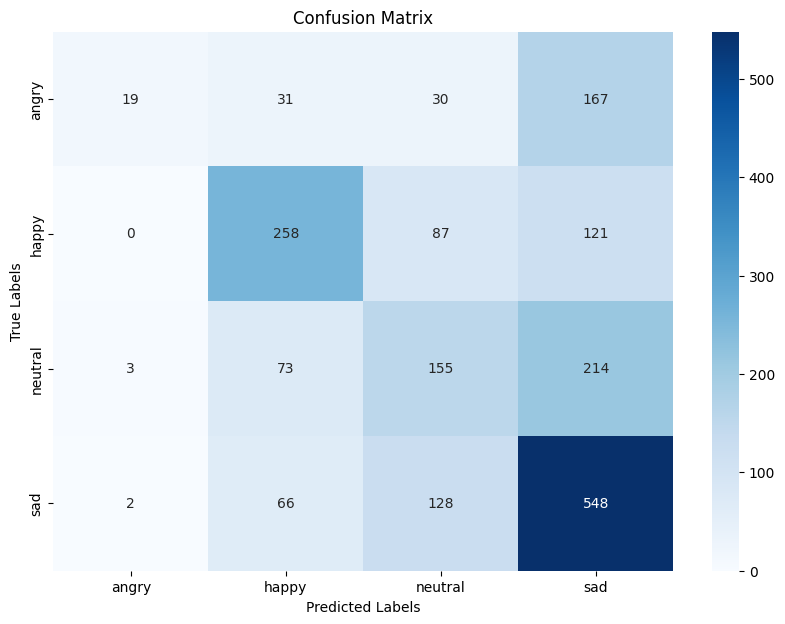

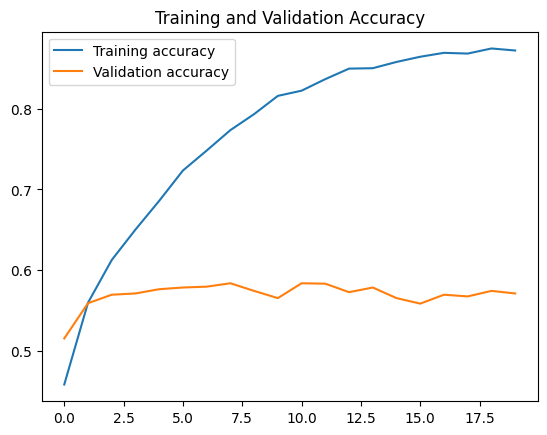

Tet Accuracy: 0.515247106552124
F1 Score: 0.4844290195916675
Confusion Matrix:
 [[ 19  31  30 167]
 [  0 258  87 121]
 [  3  73 155 214]
 [  2  66 128 548]]
*********************************************
Average F1 Score across all folds: 0.5573073405538412
Average Accuracy across all folds: 0.5686056017875671


In [13]:

def build_model():
    model = Sequential([
        Dense(256, activation='relu', input_dim=384),  # Input dimension is 384 for sBERT
        #Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
X = np.array(embeddings)  # Convert list of embeddings to a numpy array
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
f1_scores = []
accuracies = []
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = build_model()
    print(f'Training fold {fold_no}')
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

    # Evaluate the model
    test_acc, f1, cm = evaluate_model(model, X_test, y_test, history, encoder.classes_)
    print("Tet Accuracy:", test_acc)
    accuracies.append(test_acc)
    print("F1 Score:", f1)
    f1_scores.append(f1)
    print("Confusion Matrix:\n", cm)
    fold_no+=1
    print('*********************************************')



# Print average scores
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)
print(f'Average F1 Score across all folds: {average_f1_score}')
print(f'Average Accuracy across all folds: {average_accuracy}')


In [ ]:
Without DropOut "Average F1 Score across all folds: 0.5571513490281926
Average Accuracy across all folds: 0.5674487113952636"

Training fold 1
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3687 - loss: 1.3089 - val_accuracy: 0.4656 - val_loss: 1.1694
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5065 - loss: 1.1255 - val_accuracy: 0.5097 - val_loss: 1.1087
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5586 - loss: 1.0408 - val_accuracy: 0.5223 - val_loss: 1.0944
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5955 - loss: 0.9627 - val_accuracy: 0.5523 - val_loss: 1.0532
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6305 - loss: 0.9152 - val_accuracy: 0.5654 - val_loss: 1.0296
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6545 - loss: 0.8603 - val_accuracy: 0.5596 - val_loss: 1.0493
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6622 - loss: 0.8281 - val_accuracy: 0.5586 - val_loss: 1.0438
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6909 - loss: 0.7640 - val_accuracy: 0.5702

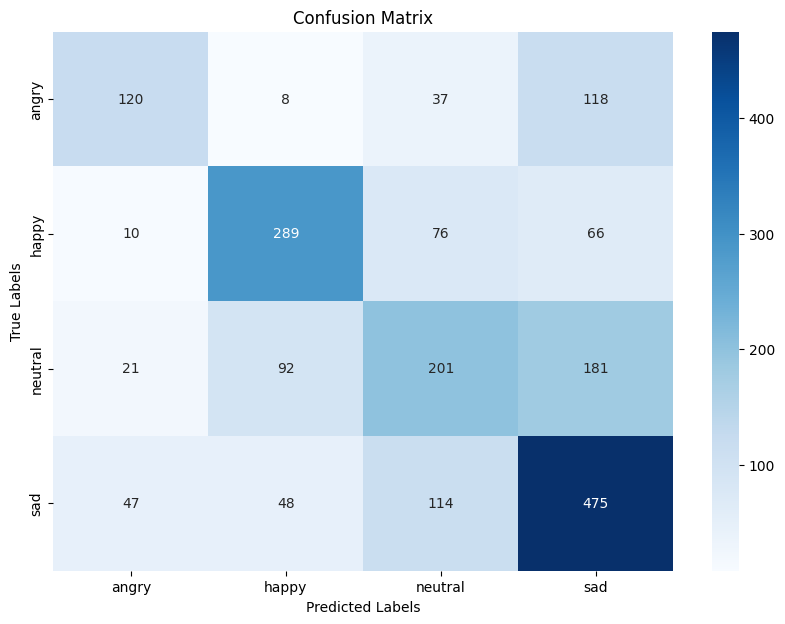

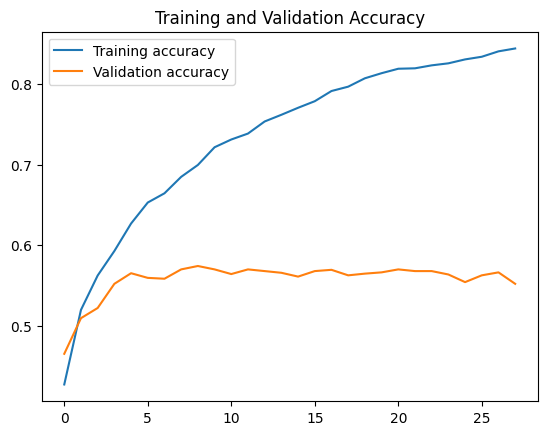

Tet Accuracy: 0.5701524019241333
F1 Score: 0.5641045026460731
Confusion Matrix:
 [[120   8  37 118]
 [ 10 289  76  66]
 [ 21  92 201 181]
 [ 47  48 114 475]]
*********************************************
Training fold 2
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3858 - loss: 1.3116 - val_accuracy: 0.4968 - val_loss: 1.1475
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5058 - loss: 1.1337 - val_accuracy: 0.5305 - val_loss: 1.0895
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5546 - loss: 1.0498 - val_accuracy: 0.5489 - val_loss: 1.0680
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5863 - loss: 0.9769 - val_accuracy: 0.5610 - val_loss: 1.0409
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6170 - loss: 0.9273 - val_accuracy: 0.5726 - val_loss: 1.0221
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6437 - loss: 0.8762 - val_accuracy: 0.5873 - val_loss: 1.0073
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6624 - loss: 0.8351 - val_accuracy: 0.5825 - val_loss: 1.0059
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6872 - loss: 0.7885 - val_accuracy: 0.58

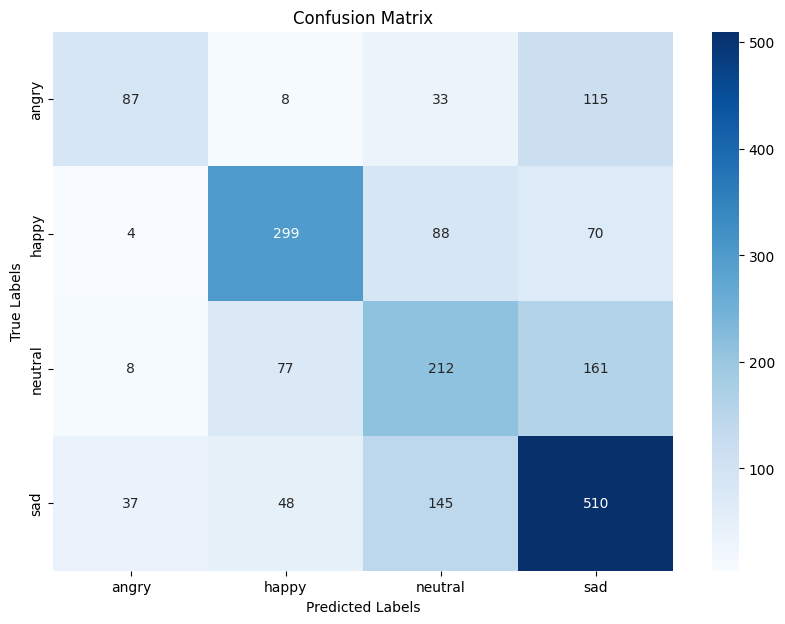

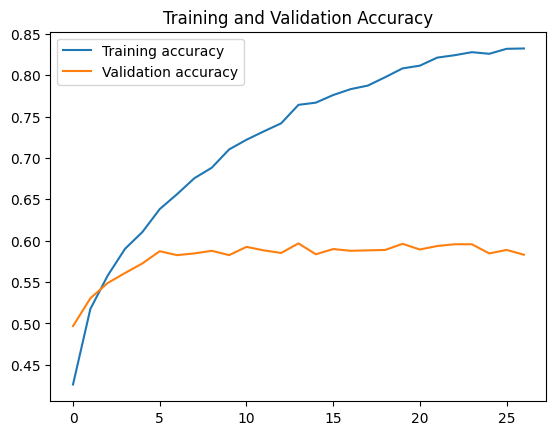

Tet Accuracy: 0.5825446844100952
F1 Score: 0.5786931587694917
Confusion Matrix:
 [[ 87   8  33 115]
 [  4 299  88  70]
 [  8  77 212 161]
 [ 37  48 145 510]]
*********************************************
Training fold 3
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3782 - loss: 1.3157 - val_accuracy: 0.4895 - val_loss: 1.1477
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4866 - loss: 1.1416 - val_accuracy: 0.5484 - val_loss: 1.0769
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5528 - loss: 1.0444 - val_accuracy: 0.5631 - val_loss: 1.0421
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5842 - loss: 0.9955 - val_accuracy: 0.5589 - val_loss: 1.0264
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6079 - loss: 0.9299 - val_accuracy: 0.5720 - val_loss: 1.0027
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6493 - loss: 0.8732 - val_accuracy: 0.5783 - val_loss: 0.9878
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6658 - loss: 0.8248 - val_accuracy: 0.5705 - val_loss: 0.9966
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6846 - loss: 0.7913 - val_accuracy: 0.58

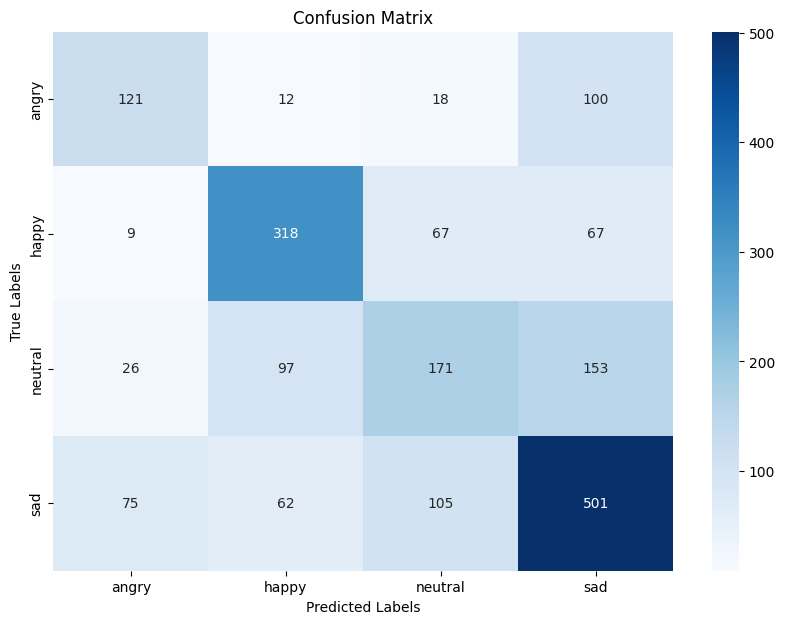

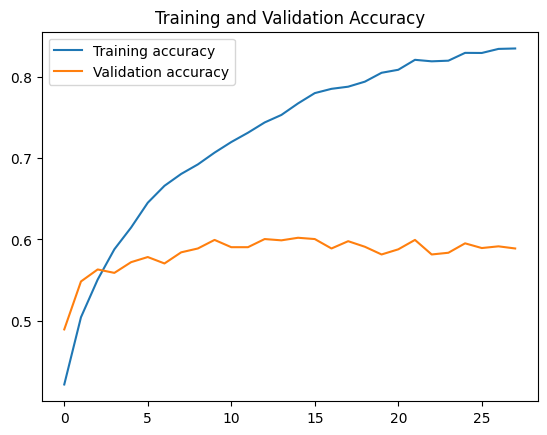

Tet Accuracy: 0.5841220021247864
F1 Score: 0.5782663916165552
Confusion Matrix:
 [[121  12  18 100]
 [  9 318  67  67]
 [ 26  97 171 153]
 [ 75  62 105 501]]
*********************************************
Training fold 4
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4028 - loss: 1.3040 - val_accuracy: 0.4879 - val_loss: 1.1381
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5197 - loss: 1.1130 - val_accuracy: 0.5305 - val_loss: 1.0723
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5498 - loss: 1.0494 - val_accuracy: 0.5531 - val_loss: 1.0309
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5963 - loss: 0.9819 - val_accuracy: 0.5741 - val_loss: 1.0003
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6171 - loss: 0.9249 - val_accuracy: 0.5868 - val_loss: 0.9809
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6411 - loss: 0.8733 - val_accuracy: 0.5952 - val_loss: 0.9691
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6585 - loss: 0.8280 - val_accuracy: 0.5967 - val_loss: 0.9674
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6707 - loss: 0.8015 - val_accuracy: 0.604

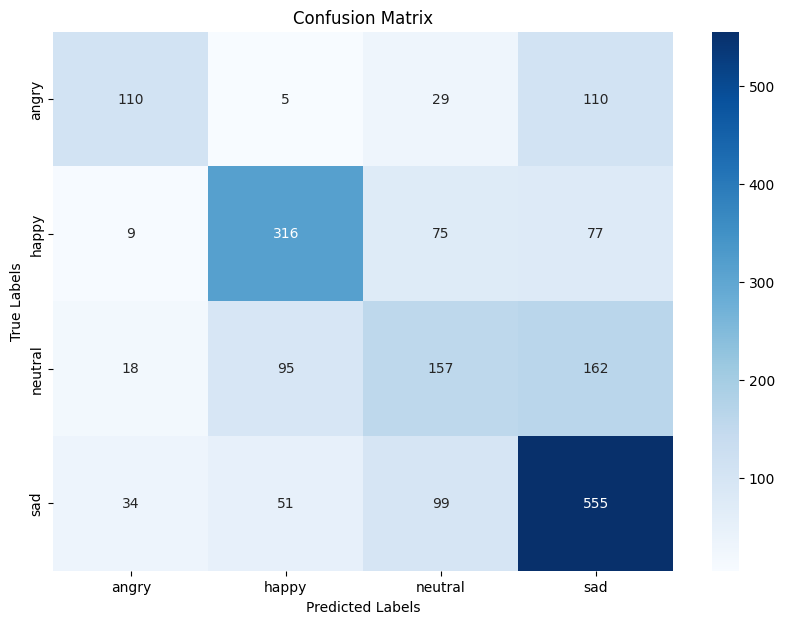

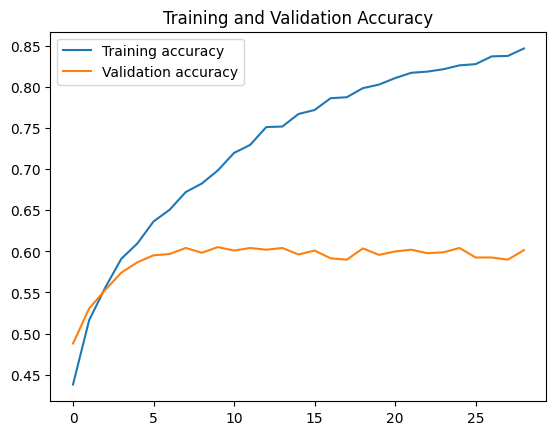

Tet Accuracy: 0.598317563533783
F1 Score: 0.5895720715781766
Confusion Matrix:
 [[110   5  29 110]
 [  9 316  75  77]
 [ 18  95 157 162]
 [ 34  51  99 555]]
*********************************************
Training fold 5
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3965 - loss: 1.3027 - val_accuracy: 0.4963 - val_loss: 1.1524
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5053 - loss: 1.1195 - val_accuracy: 0.5247 - val_loss: 1.0951
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5611 - loss: 1.0407 - val_accuracy: 0.5436 - val_loss: 1.0676
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5946 - loss: 0.9753 - val_accuracy: 0.5626 - val_loss: 1.0399
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6198 - loss: 0.9312 - val_accuracy: 0.5678 - val_loss: 1.0309
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6507 - loss: 0.8727 - val_accuracy: 0.5741 - val_loss: 1.0207
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6668 - loss: 0.8195 - val_accuracy: 0.5747 - val_loss: 1.0142
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6793 - loss: 0.7803 - val_accuracy: 0.577

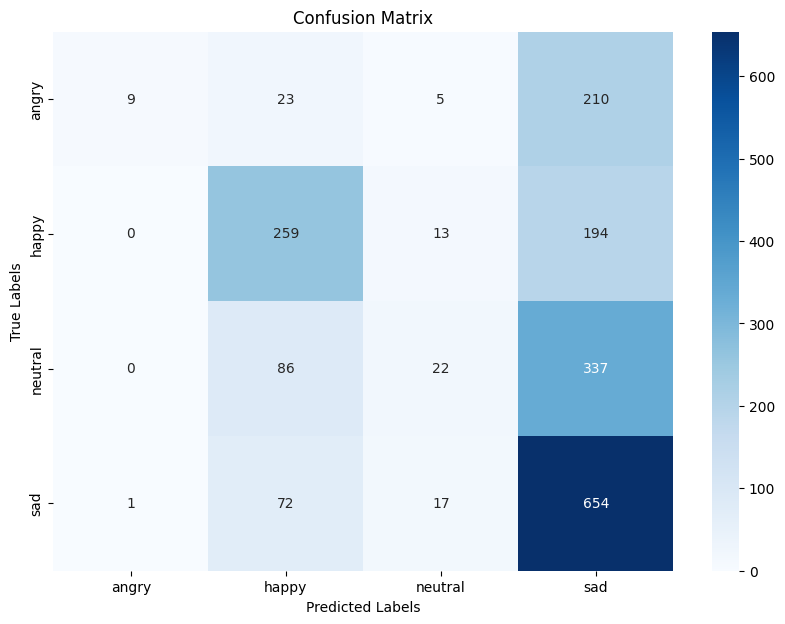

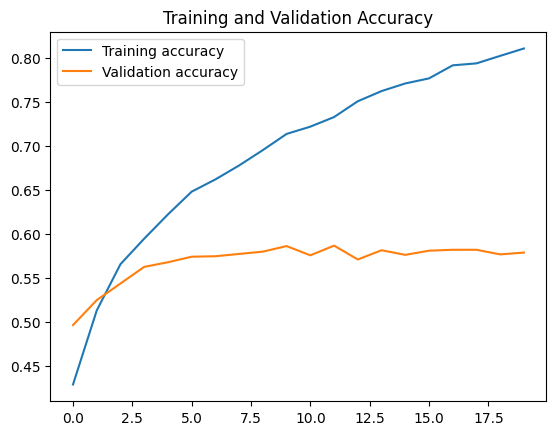

Tet Accuracy: 0.49631965160369873
F1 Score: 0.40888159189247886
Confusion Matrix:
 [[  9  23   5 210]
 [  0 259  13 194]
 [  0  86  22 337]
 [  1  72  17 654]]
*********************************************
Average F1 Score across all folds: 0.5439035433005552
Average Accuracy across all folds: 0.5662912607192994


In [14]:
def build_model():
    model = Sequential([
        Dense(256, activation='relu', input_dim=384),
        Dropout(0.3),  # Adjusted dropout
        Dense(128, activation='relu'),
        Dropout(0.3),  # Adjusted dropout
        Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),  # Adjusted learning rate
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model
X = np.array(embeddings)  # Convert list of embeddings to a numpy array
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
f1_scores = []
accuracies = []
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = build_model()
    print(f'Training fold {fold_no}')
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

    # Evaluate the model
    test_acc, f1, cm = evaluate_model(model, X_test, y_test, history, encoder.classes_)
    print("Tet Accuracy:", test_acc)
    accuracies.append(test_acc)
    print("F1 Score:", f1)
    f1_scores.append(f1)
    print("Confusion Matrix:\n", cm)
    fold_no+=1
    print('*********************************************')



# Print average scores
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)
print(f'Average F1 Score across all folds: {average_f1_score}')
print(f'Average Accuracy across all folds: {average_accuracy}')

# Doing Grid Search

In [ ]:
! pip install scikeras


In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

def build_model(dropout_rate=0.5, optimizer='adam', learning_rate=0.001):
    model = Sequential([
        Dense(256, activation='relu', input_dim=384),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(output_size, activation='softmax')
    ])
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Using verbose=1 for KerasClassifier to show progress for each epoch
model = KerasClassifier(model=build_model, dropout_rate=0.5, optimizer='adam', learning_rate=0.001, batch_size=32, epochs=100, verbose=1)

param_grid = {
    'model__dropout_rate': [0.3, 0.5, 0.7],
    'model__optimizer': ['adam', 'sgd'],
    'model__learning_rate': [0.001, 0.01, 0.0001],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

# Using verbose=2 for GridSearchCV to show messages for each fit of the model
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy', verbose=2)
grid_result = grid.fit(X, y)  # X and y should be pre-defined data and labels

# Print the best parameters and the best score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3658 - loss: 1.3183
Epoch 2/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4745 - loss: 1.1813
Epoch 3/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5142 - loss: 1.1341
Epoch 4/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5360 - loss: 1.0783
Epoch 5/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5557 - loss: 1.0411
Epoch 6/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5706 - loss: 1.0121
Epoch 7/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5908 - loss: 0.9759
Epoch 8/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6043 - loss: 0.9407
Epoch 9/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6029 - loss: 0.9413
Epoch 10/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6184 - loss: 0.9199
Epoch 11/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6286 - loss: 0.9005
Epoch 12/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

# Using values from Grid Search

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training fold 1
Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3587 - loss: 1.3352 - val_accuracy: 0.4325 - val_loss: 1.2314
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4555 - loss: 1.2192 - val_accuracy: 0.4677 - val_loss: 1.1532
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4959 - loss: 1.1440 - val_accuracy: 0.4861 - val_loss: 1.1199
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5284 - loss: 1.1092 - val_accuracy: 0.5087 - val_loss: 1.0959
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5553 - loss: 1.0465 - val_accuracy: 0.5307 - val_loss: 1.0681
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5626 - loss: 1.0195 - val_accuracy: 0.5460 - val_loss: 1.0449
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5756 - loss: 0.9844 - val_accuracy: 0.5607 - val_loss: 1.0292
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5930 - loss: 

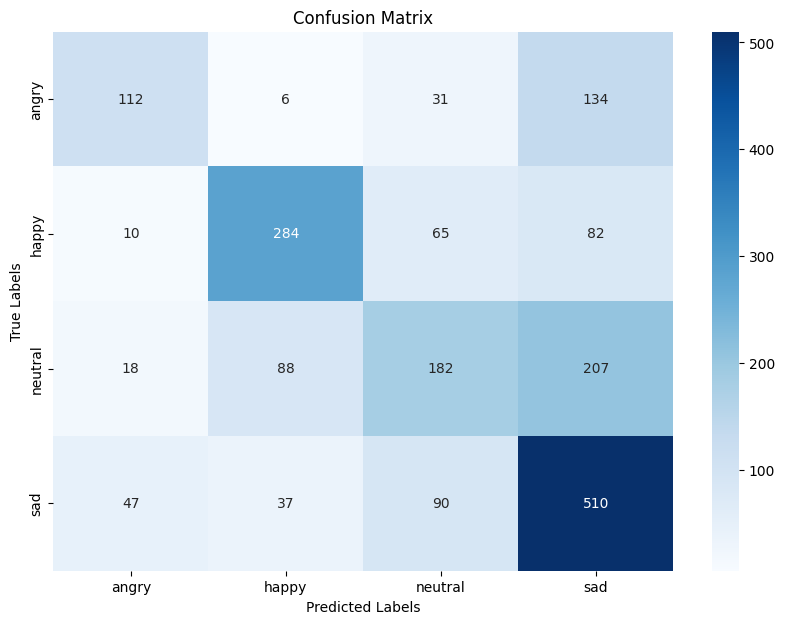

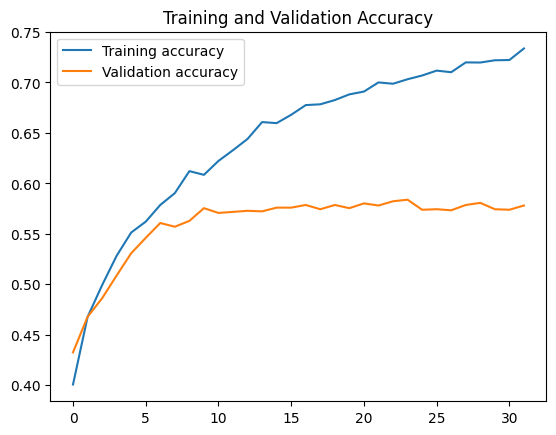

Tet Accuracy: 0.5717288255691528
F1 Score: 0.5610886784917499
Confusion Matrix:
 [[112   6  31 134]
 [ 10 284  65  82]
 [ 18  88 182 207]
 [ 47  37  90 510]]
*********************************************
Training fold 2
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3586 - loss: 1.3271 - val_accuracy: 0.4706 - val_loss: 1.1959
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4550 - loss: 1.2125 - val_accuracy: 0.5047 - val_loss: 1.1345
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4943 - loss: 1.1473 - val_accuracy: 0.5216 - val_loss: 1.0962
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5073 - loss: 1.1025 - val_accuracy: 0.5452 - val_loss: 1.0732
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5525 - loss: 1.0449 - val_accuracy: 0.5547 - val_loss: 1.0514
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5639 - loss: 1.0316 - val_accuracy: 0.5594 - val_loss: 1.0359
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5720 - loss: 0.9894 - val_accuracy: 0.5694 - val_loss: 1.0243
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5874 - loss: 0.9664 - val_accuracy: 0.57

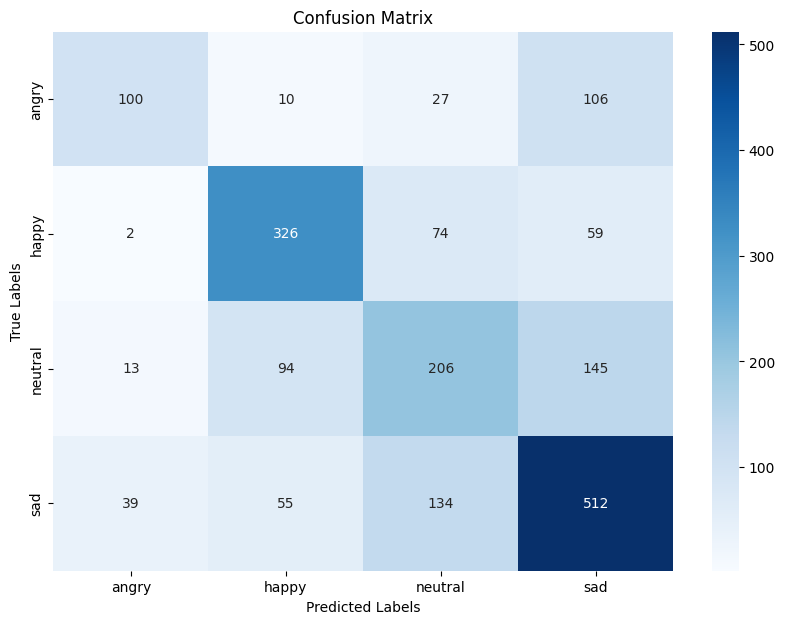

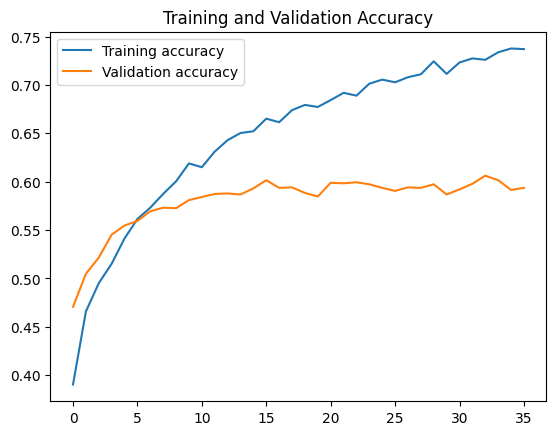

Tet Accuracy: 0.6014721393585205
F1 Score: 0.5968268145183334
Confusion Matrix:
 [[100  10  27 106]
 [  2 326  74  59]
 [ 13  94 206 145]
 [ 39  55 134 512]]
*********************************************
Training fold 3
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3565 - loss: 1.3318 - val_accuracy: 0.4732 - val_loss: 1.2124
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4485 - loss: 1.2278 - val_accuracy: 0.5095 - val_loss: 1.1150
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4966 - loss: 1.1475 - val_accuracy: 0.5368 - val_loss: 1.0796
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5198 - loss: 1.1032 - val_accuracy: 0.5536 - val_loss: 1.0508
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5486 - loss: 1.0529 - val_accuracy: 0.5641 - val_loss: 1.0306
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5727 - loss: 1.0157 - val_accuracy: 0.5857 - val_loss: 1.0076
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5966 - loss: 0.9898 - val_accuracy: 0.5889 - val_loss: 0.9946
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5907 - loss: 0.9568 - val_accuracy: 0.5852

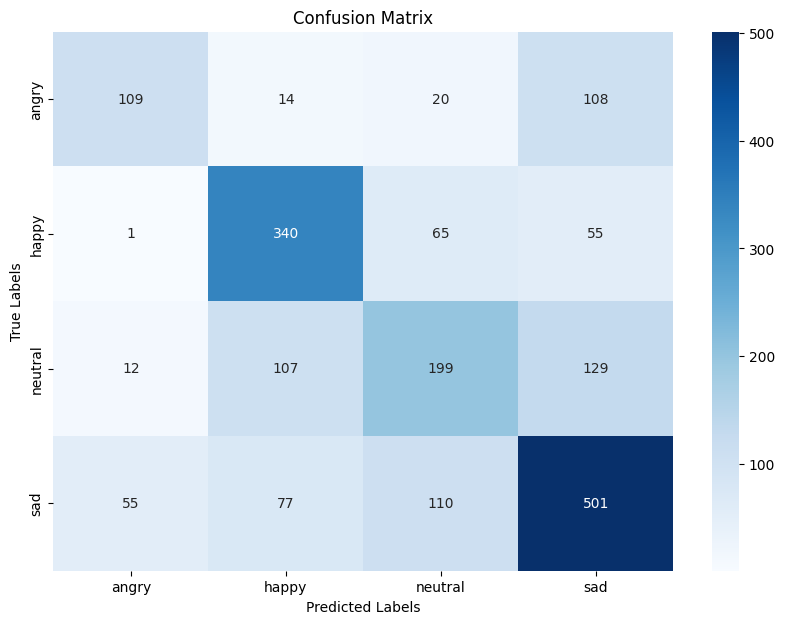

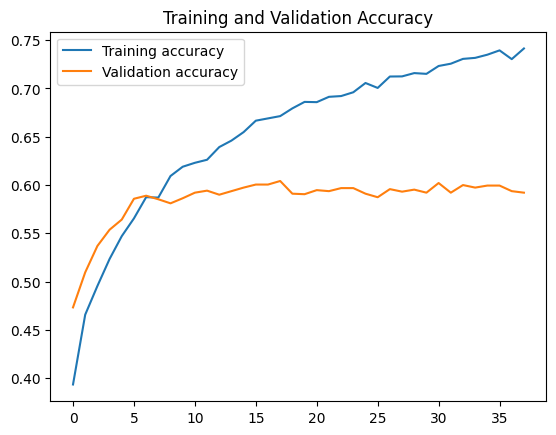

Tet Accuracy: 0.6041009426116943
F1 Score: 0.5982502718341058
Confusion Matrix:
 [[109  14  20 108]
 [  1 340  65  55]
 [ 12 107 199 129]
 [ 55  77 110 501]]
*********************************************
Training fold 4
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3743 - loss: 1.3317 - val_accuracy: 0.4884 - val_loss: 1.2016
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4647 - loss: 1.2052 - val_accuracy: 0.4932 - val_loss: 1.1256
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4952 - loss: 1.1507 - val_accuracy: 0.5279 - val_loss: 1.0860
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5151 - loss: 1.1123 - val_accuracy: 0.5379 - val_loss: 1.0452
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5296 - loss: 1.0764 - val_accuracy: 0.5662 - val_loss: 1.0231
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5455 - loss: 1.0340 - val_accuracy: 0.5741 - val_loss: 1.0030
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5803 - loss: 0.9973 - val_accuracy: 0.5868 - val_loss: 0.9796
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5933 - loss: 0.9687 - val_accuracy: 0.586

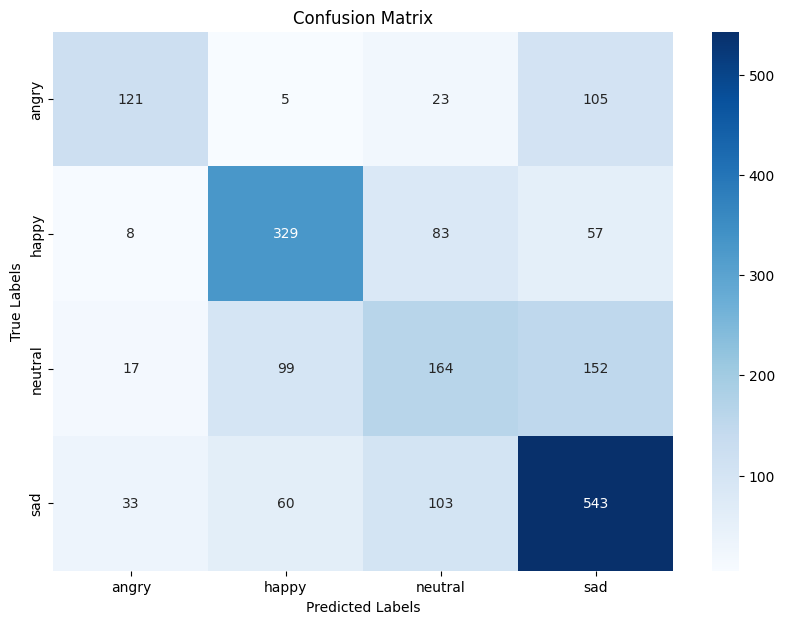

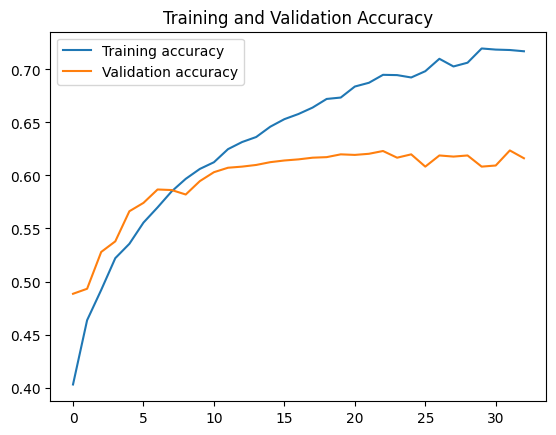

Tet Accuracy: 0.6083070635795593
F1 Score: 0.6016850077142658
Confusion Matrix:
 [[121   5  23 105]
 [  8 329  83  57]
 [ 17  99 164 152]
 [ 33  60 103 543]]
*********************************************
Training fold 5
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3481 - loss: 1.3307 - val_accuracy: 0.4758 - val_loss: 1.1908
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4586 - loss: 1.2041 - val_accuracy: 0.5058 - val_loss: 1.1247
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4890 - loss: 1.1467 - val_accuracy: 0.5237 - val_loss: 1.0948
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5248 - loss: 1.0982 - val_accuracy: 0.5489 - val_loss: 1.0631
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5419 - loss: 1.0574 - val_accuracy: 0.5631 - val_loss: 1.0466
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5804 - loss: 1.0125 - val_accuracy: 0.5668 - val_loss: 1.0282
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5890 - loss: 0.9686 - val_accuracy: 0.5768 - val_loss: 1.0212
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5951 - loss: 0.9505 - val_accuracy: 0.573

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


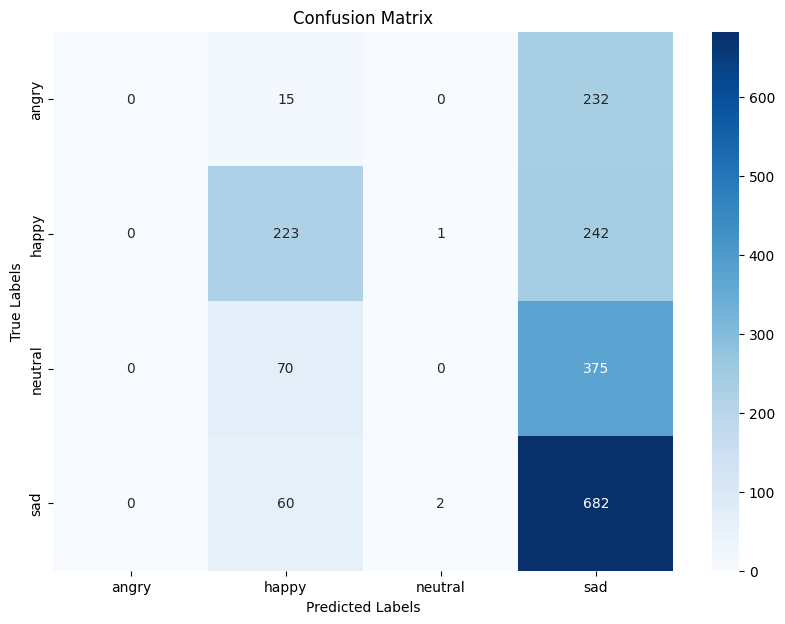

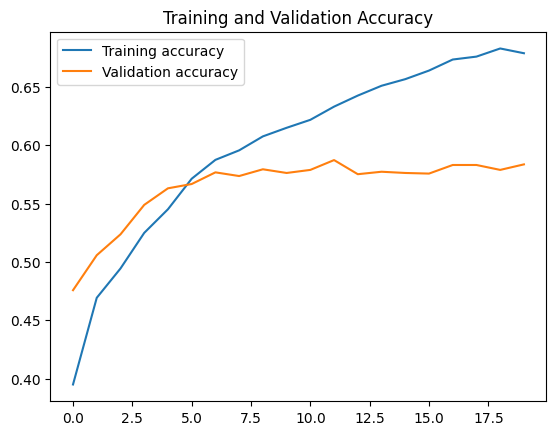

Tet Accuracy: 0.47581493854522705
F1 Score: 0.36555037011746727
Confusion Matrix:
 [[  0  15   0 232]
 [  0 223   1 242]
 [  0  70   0 375]
 [  0  60   2 682]]
*********************************************
Average F1 Score across all folds: 0.5446802285351844
Average Accuracy across all folds: 0.5722847819328308


In [15]:
def build_model():
    model = Sequential([
        Dense(256, activation='relu', input_dim=384),
        Dropout(0.7),  # Adjusted dropout
        Dense(128, activation='relu'),
        Dropout(0.7),  # Adjusted dropout
        Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),  # Adjusted learning rate
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model
X = np.array(embeddings)  # Convert list of embeddings to a numpy array
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
f1_scores = []
accuracies = []
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = build_model()
    print(f'Training fold {fold_no}')
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

    # Evaluate the model
    test_acc, f1, cm = evaluate_model(model, X_test, y_test, history, encoder.classes_)
    print("Tet Accuracy:", test_acc)
    accuracies.append(test_acc)
    print("F1 Score:", f1)
    f1_scores.append(f1)
    print("Confusion Matrix:\n", cm)
    fold_no+=1
    print('*********************************************')



# Print average scores
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)
print(f'Average F1 Score across all folds: {average_f1_score}')
print(f'Average Accuracy across all folds: {average_accuracy}')

# Dealing whith imbalanced class

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

Training fold 1
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2911 - loss: 1.3654 - val_accuracy: 0.4330 - val_loss: 1.2709
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3871 - loss: 1.2506 - val_accuracy: 0.4514 - val_loss: 1.1833
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4437 - loss: 1.1794 - val_accuracy: 0.4745 - val_loss: 1.1446
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4601 - loss: 1.1223 - val_accuracy: 0.4966 - val_loss: 1.1104
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4997 - loss: 1.0831 - val_accuracy: 0.5229 - val_loss: 1.0752
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5112 - loss: 1.0642 - val_accuracy: 0.5413 - val_loss: 1.0515
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5505 - loss: 1.0207 - val_accuracy: 0.5418 - val_loss: 1.0433
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5495 - loss: 0.9849 - val_accuracy: 0.546

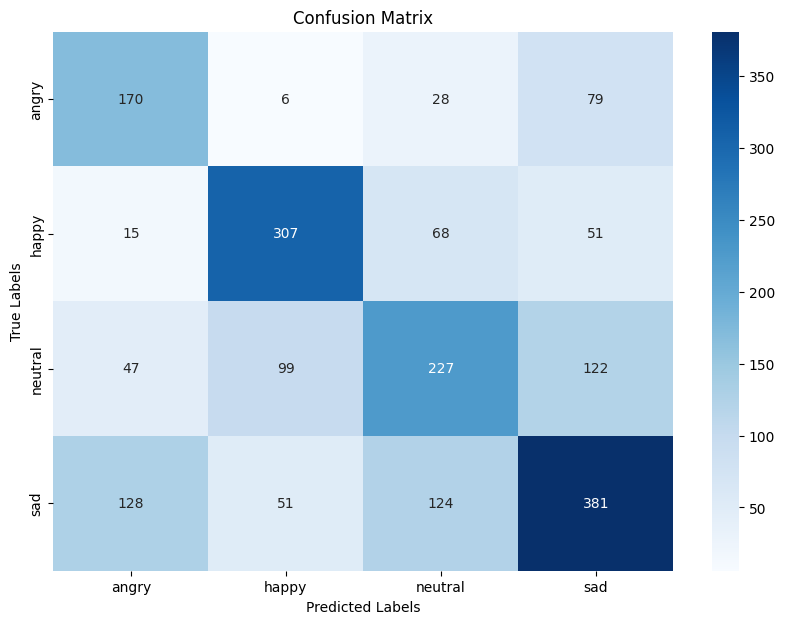

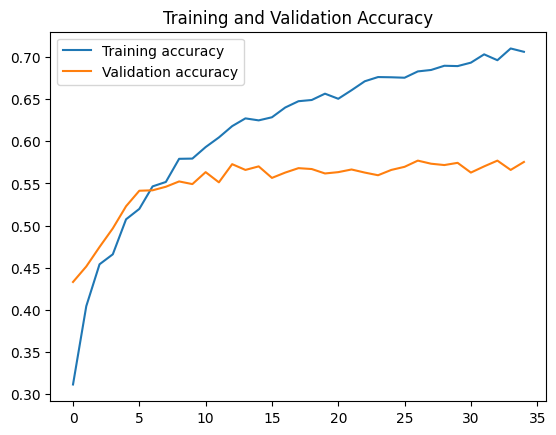

Test Accuracy: 0.5701524019241333
F1 Score: 0.5693599201713839
Confusion Matrix:
 [[170   6  28  79]
 [ 15 307  68  51]
 [ 47  99 227 122]
 [128  51 124 381]]
*********************************************
Training fold 2
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2790 - loss: 1.3806 - val_accuracy: 0.4117 - val_loss: 1.2655
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3975 - loss: 1.2568 - val_accuracy: 0.4658 - val_loss: 1.1804
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4603 - loss: 1.1613 - val_accuracy: 0.4600 - val_loss: 1.1722
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4857 - loss: 1.1101 - val_accuracy: 0.4853 - val_loss: 1.1451
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5041 - loss: 1.0832 - val_accuracy: 0.5121 - val_loss: 1.1005
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5270 - loss: 1.0486 - val_accuracy: 0.5000 - val_loss: 1.1051
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5320 - loss: 1.0178 - val_accuracy: 0.5252 - val_loss: 1.0677
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5587 - loss: 0.9692 - val_accuracy: 0.545

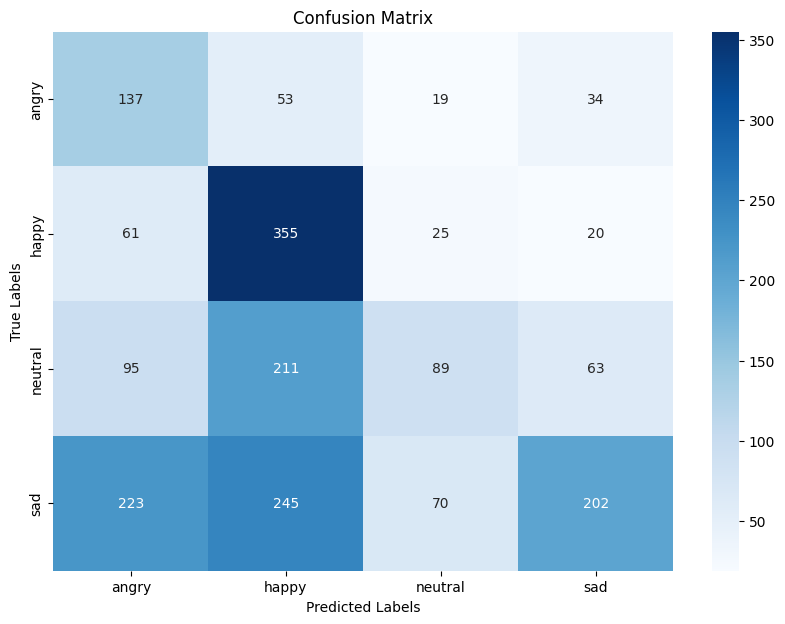

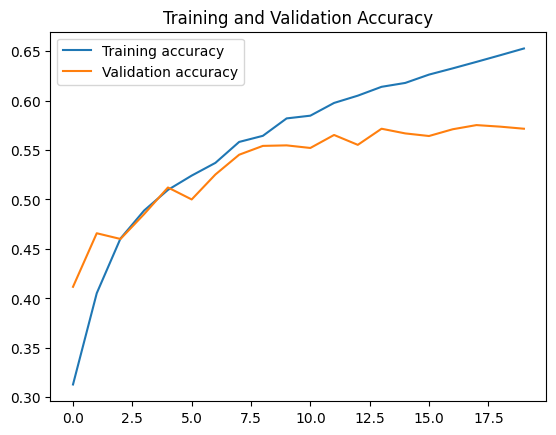

Test Accuracy: 0.4116719365119934
F1 Score: 0.3892682111424906
Confusion Matrix:
 [[137  53  19  34]
 [ 61 355  25  20]
 [ 95 211  89  63]
 [223 245  70 202]]
*********************************************
Training fold 3
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3049 - loss: 1.3614 - val_accuracy: 0.3460 - val_loss: 1.2960
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3937 - loss: 1.2650 - val_accuracy: 0.4406 - val_loss: 1.1879
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4405 - loss: 1.1974 - val_accuracy: 0.4837 - val_loss: 1.1336
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4677 - loss: 1.1382 - val_accuracy: 0.5058 - val_loss: 1.0995
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5030 - loss: 1.0794 - val_accuracy: 0.5063 - val_loss: 1.0841
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5142 - loss: 1.0639 - val_accuracy: 0.5263 - val_loss: 1.0657
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5273 - loss: 1.0309 - val_accuracy: 0.5252 - val_loss: 1.0707
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5443 - loss: 0.9771 - val_accuracy: 0.524

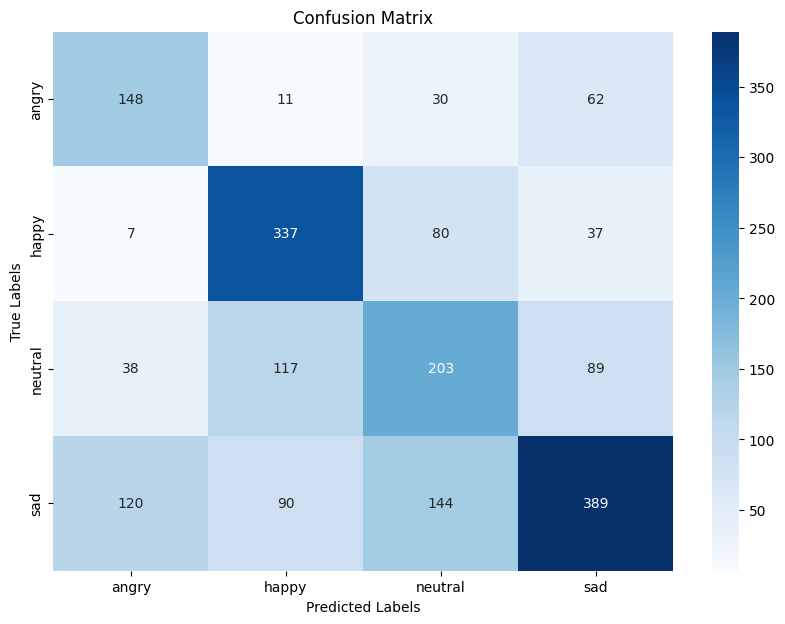

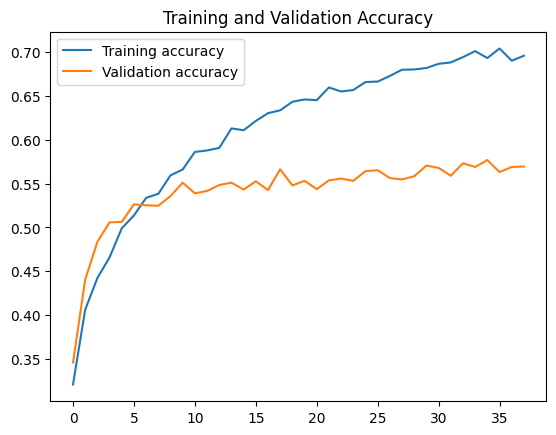

Test Accuracy: 0.5662460327148438
F1 Score: 0.5658388456067776
Confusion Matrix:
 [[148  11  30  62]
 [  7 337  80  37]
 [ 38 117 203  89]
 [120  90 144 389]]
*********************************************
Training fold 4
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2786 - loss: 1.3870 - val_accuracy: 0.4464 - val_loss: 1.2672
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3926 - loss: 1.2643 - val_accuracy: 0.4637 - val_loss: 1.1776
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4451 - loss: 1.1744 - val_accuracy: 0.4674 - val_loss: 1.1490
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4782 - loss: 1.1198 - val_accuracy: 0.4874 - val_loss: 1.1166
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4936 - loss: 1.0964 - val_accuracy: 0.5000 - val_loss: 1.0913
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5190 - loss: 1.0484 - val_accuracy: 0.5426 - val_loss: 1.0398
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5412 - loss: 1.0146 - val_accuracy: 0.5510 - val_loss: 1.0316
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5505 - loss: 0.9867 - val_accuracy: 0.536

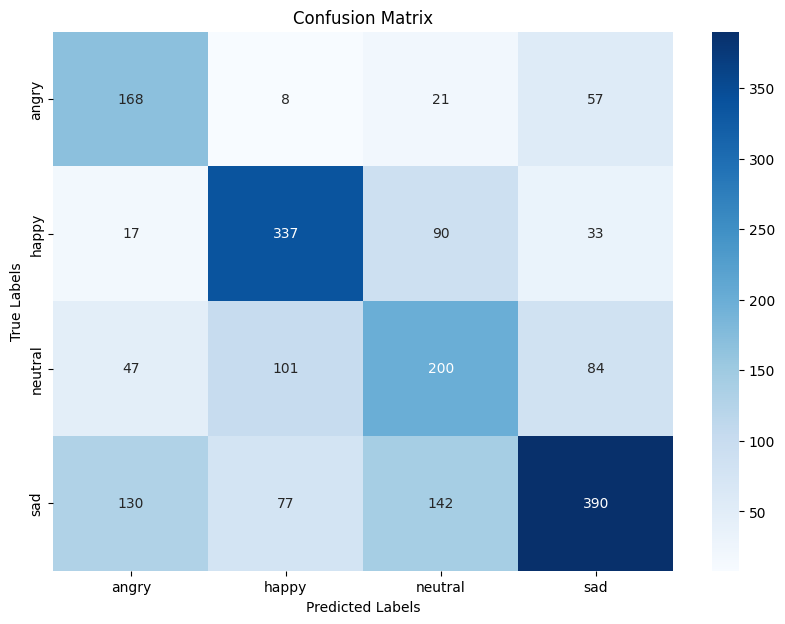

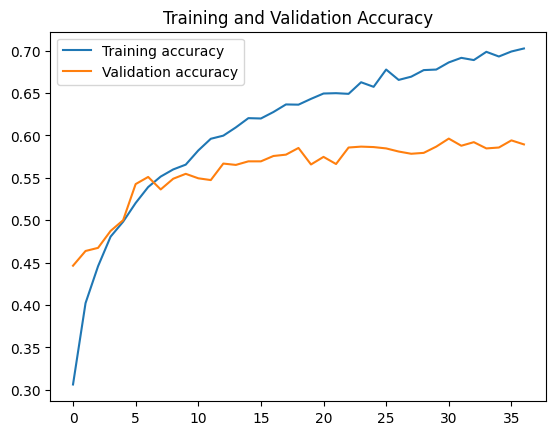

Test Accuracy: 0.5757097601890564
F1 Score: 0.5771171487536922
Confusion Matrix:
 [[168   8  21  57]
 [ 17 337  90  33]
 [ 47 101 200  84]
 [130  77 142 390]]
*********************************************
Training fold 5
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2993 - loss: 1.3849 - val_accuracy: 0.4190 - val_loss: 1.2641
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3904 - loss: 1.2628 - val_accuracy: 0.4422 - val_loss: 1.1876
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4461 - loss: 1.1719 - val_accuracy: 0.4422 - val_loss: 1.1633
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4724 - loss: 1.1151 - val_accuracy: 0.4884 - val_loss: 1.1114
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4937 - loss: 1.0785 - val_accuracy: 0.5037 - val_loss: 1.0937
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5164 - loss: 1.0460 - val_accuracy: 0.5079 - val_loss: 1.0799
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5399 - loss: 1.0094 - val_accuracy: 0.5158 - val_loss: 1.0707
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5489 - loss: 0.9847 - val_accuracy: 0.513

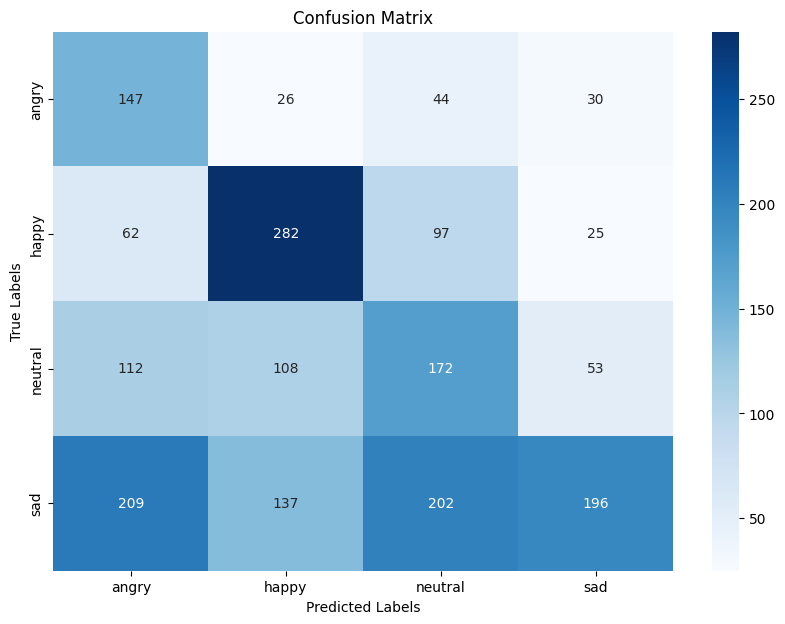

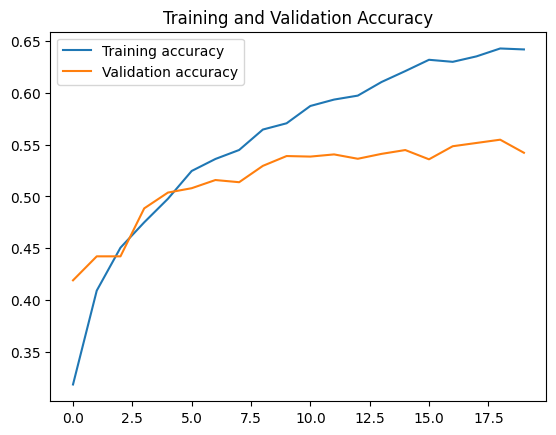

Test Accuracy: 0.41903260350227356
F1 Score: 0.41489554337313206
Confusion Matrix:
 [[147  26  44  30]
 [ 62 282  97  25]
 [112 108 172  53]
 [209 137 202 196]]
*********************************************
Average F1 Score across all folds: 0.5032959338094953
Average Accuracy across all folds: 0.50856254696846


In [16]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Load and encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(merged_df['Emotion'])
y = tf.keras.utils.to_categorical(y)  # Convert labels to one-hot encoding
output_size = len(encoder.classes_)

# Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
transcripts = merged_df['Transcript'].tolist()
embeddings = model.encode(transcripts, show_progress_bar=True)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y.argmax(axis=1)), y=y.argmax(axis=1))
class_weights_dict = dict(enumerate(class_weights))

def build_model():
    model = Sequential([
        Dense(256, activation='relu', input_dim=384),
        Dropout(0.7),  # Adjusted dropout
        Dense(128, activation='relu'),
        Dropout(0.7),  # Adjusted dropout
        Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),  # Adjusted learning rate
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

X = np.array(embeddings)  # Convert list of embeddings to a numpy array
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
f1_scores = []
accuracies = []
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = build_model()
    print(f'Training fold {fold_no}')
    history = model.fit(X_train, y_train, class_weight=class_weights_dict, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

    # Evaluate the model
    test_acc, f1, cm = evaluate_model(model, X_test, y_test, history, encoder.classes_)
    print("Test Accuracy:", test_acc)
    accuracies.append(test_acc)
    print("F1 Score:", f1)
    f1_scores.append(f1)
    print("Confusion Matrix:\n", cm)
    fold_no += 1
    print('*********************************************')

# Print average scores
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)
print(f'Average F1 Score across all folds: {average_f1_score}')
print(f'Average Accuracy across all folds: {average_accuracy}')


In [17]:
class_weights_dict

{0: 1.8605242566510172,
 1: 1.0311144839549002,
 2: 1.0442468159859464,
 3: 0.6514383561643836}

In [23]:

from imblearn.over_sampling import SMOTE


# Load SentenceTransformer model and generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
transcripts = merged_df['Transcript'].tolist()
embeddings = model.encode(transcripts, show_progress_bar=True)

# Label encoding and convert to one-hot
encoder = LabelEncoder()
y = encoder.fit_transform(merged_df['Emotion'])
y = tf.keras.utils.to_categorical(y)
output_size = len(encoder.classes_)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

# Apply SMOTE to generate synthetic samples for balancing the dataset
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.argmax(axis=1))
y_train_res = tf.keras.utils.to_categorical(y_train_res)  # Convert labels back to categorical

# Define the model architecture
def build_model():
    model = Sequential([
        Dense(256, activation='relu', input_dim=384),
        Dropout(0.7),
        Dense(128, activation='relu'),
        Dropout(0.7),
        Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Training the model with K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
f1_scores = []
accuracies = []

for train_index, test_index in kf.split(X_train_res):
    X_train_kf, X_test_kf = X_train_res[train_index], X_train_res[test_index]
    y_train_kf, y_test_kf = y_train_res[train_index], y_train_res[test_index]

    model = build_model()
    print(f'Training fold {fold_no}')
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    history = model.fit(X_train_kf, y_train_kf, epochs=100, validation_data=(X_test_kf, y_test_kf), batch_size=32)#, callbacks=[early_stopping])

    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test_kf), axis=1)
    y_true = np.argmax(y_test_kf, axis=1)
    test_acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    accuracies.append(test_acc)
    f1_scores.append(f1)
    print("Test Accuracy:", test_acc)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", cm)
    fold_no += 1
    print('*********************************************')

# Print average scores
average_f1_score = np.mean(f1_scores)
average_accuracy = np.mean(accuracies)
print(f'Average F1 Score across all folds: {average_f1_score}')
print(f'Average Accuracy across all folds: {average_accuracy}')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

Training fold 1
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3050 - loss: 1.3623 - val_accuracy: 0.5086 - val_loss: 1.1633
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4661 - loss: 1.1788 - val_accuracy: 0.5647 - val_loss: 1.0513
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5258 - loss: 1.0945 - val_accuracy: 0.5971 - val_loss: 0.9817
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5765 - loss: 1.0212 - val_accuracy: 0.6292 - val_loss: 0.9278
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5982 - loss: 0.9732 - val_accuracy: 0.6448 - val_loss: 0.8827
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6165 - loss: 0.9101 - val_accuracy: 0.6629 - val_loss: 0.8486
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6459 - loss: 0.8693 - val_accuracy: 0.6671 - val_loss: 0.8398
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6580 - loss: 0.8474 - val_accuracy: 0.679

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3148 - loss: 1.3583 - val_accuracy: 0.5086 - val_loss: 1.1492
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4743 - loss: 1.1803 - val_accuracy: 0.5563 - val_loss: 1.0531
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5372 - loss: 1.0790 - val_accuracy: 0.5946 - val_loss: 0.9743
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5629 - loss: 1.0102 - val_accuracy: 0.6153 - val_loss: 0.9297
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6008 - loss: 0.9599 - val_accuracy: 0.6401 - val_loss: 0.8863
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6296 - loss: 0.9087 - val_accuracy: 0.6578 - val_loss: 0.8465
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6376 - loss: 0.8890 - val_accuracy: 0.6789 - val_loss: 0.8235
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6671 - loss: 0.8335 - val_accuracy: 0.6839

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3248 - loss: 1.3557 - val_accuracy: 0.4707 - val_loss: 1.1714
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4767 - loss: 1.1705 - val_accuracy: 0.5306 - val_loss: 1.0716
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5291 - loss: 1.0895 - val_accuracy: 0.5697 - val_loss: 1.0080
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5707 - loss: 1.0060 - val_accuracy: 0.5904 - val_loss: 0.9565
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6045 - loss: 0.9530 - val_accuracy: 0.6203 - val_loss: 0.9131
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6306 - loss: 0.9093 - val_accuracy: 0.6405 - val_loss: 0.8800
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6423 - loss: 0.8774 - val_accuracy: 0.6599 - val_loss: 0.8496
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6573 - loss: 0.8508 - val_accuracy: 0.6717

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3077 - loss: 1.3637 - val_accuracy: 0.5023 - val_loss: 1.1601
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4853 - loss: 1.1713 - val_accuracy: 0.5411 - val_loss: 1.0490
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5341 - loss: 1.0819 - val_accuracy: 0.5765 - val_loss: 0.9782
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5684 - loss: 1.0184 - val_accuracy: 0.6136 - val_loss: 0.9195
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6017 - loss: 0.9526 - val_accuracy: 0.6275 - val_loss: 0.8815
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6214 - loss: 0.9256 - val_accuracy: 0.6464 - val_loss: 0.8551
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6508 - loss: 0.8679 - val_accuracy: 0.6734 - val_loss: 0.8271
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6729 - loss: 0.8307 - val_accuracy: 0.686

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3055 - loss: 1.3612 - val_accuracy: 0.4916 - val_loss: 1.1569
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4795 - loss: 1.1723 - val_accuracy: 0.5489 - val_loss: 1.0579
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5329 - loss: 1.0860 - val_accuracy: 0.5725 - val_loss: 1.0010
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5720 - loss: 1.0127 - val_accuracy: 0.6079 - val_loss: 0.9507
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5910 - loss: 0.9579 - val_accuracy: 0.6324 - val_loss: 0.9068
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6270 - loss: 0.9078 - val_accuracy: 0.6471 - val_loss: 0.8756
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6495 - loss: 0.8558 - val_accuracy: 0.6526 - val_loss: 0.8603
Epoch 8/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6628 - loss: 0.8288 - val_accuracy: 0.65

Average F1 Score across all folds: 0.740423011658815
Average Accuracy across all folds: 0.7417396312790963